In [73]:
from scipy import stats
from sklearn.datasets import make_spd_matrix
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [74]:
def sample_mix(size, dist1, dist2, mean_2, **params2):
    sampled_1 = dist1.rvs(size=size)
    sampled_2 = dist2.rvs(**params2, size=size)
    bern = stats.bernoulli.rvs(p=0.7, size=size)
    return sampled_1 * bern + (sampled_2 - mean_2)* (1 - bern)

matrices = {}
for d in [50]:
    matrices[d] = make_spd_matrix(n_dim=d)
dist_from_solution = 5 

In [75]:
class SGDBasedMethod:

    def __init__(self, stoc_grad_samples=1, dim=2, name=None):
        self.stoc_grad_samples = stoc_grad_samples
        self.dim = dim
        self.curr_pos = np.random.random(size=dim)
        self.name = name

    def stoc_agg(self, stocs):
        return stocs[0]

    def init_method(self, func, learning_rate=None, curr_pos=None, optimal=None):
        if curr_pos is None:
            curr_pos = np.random.random(size=self.dim)
        if learning_rate is None:
            learning_rate = 0.001
        self.lr = learning_rate
        self.curr_pos = curr_pos
        self.err = []
        self.dst = []
        self.f = func
        if optimal is None:
            optimal = np.zeros(shape=self.dim)
        self.opt = optimal
    
    def step(self, stocs, **params):
        self.curr_pos -= self.lr * self.stoc_agg(stocs, **params)
        self.err.append(self.f(self.curr_pos) - self.f(self.opt))
        self.dst.append(np.linalg.norm(self.curr_pos - self.opt))

class SGDClipped(SGDBasedMethod):

    def stoc_agg(self, stocs, clip_param=1, **params):
        stocs_mean = np.mean(stocs, axis=0)
        nrm = np.linalg.norm(stocs_mean)
        if nrm > clip_param:
            stocs_mean /= nrm 
            stocs_mean *= clip_param
        return stocs_mean
    
class SGDMedian(SGDBasedMethod):

    def stoc_agg(self, stocs, **params):
        return np.median(stocs, axis=0)
    
class SGDClippedMedians(SGDBasedMethod):

    def stoc_agg(self, stocs, **params):
        stoc = np.median(stocs, axis=0)
        clip_param = params["clip_param"]
        nrm = np.linalg.norm(stoc)
        if nrm > clip_param:
            stoc /= nrm
            stoc *= clip_param
        return stoc
    
class SGDMeanOfClipped(SGDBasedMethod):

    def stoc_agg(self, stocs, **params):
        clip_param = params["clip_param"]
        for i in range(stocs.shape[0]):
            nrm = np.linalg.norm(stocs[i])
            if nrm > clip_param:
                stocs[i] /= nrm
                stocs[i] *= clip_param
        return np.mean(stocs, axis=0)
    
class SmoothedMedianOfMeans(SGDBasedMethod):

    def stoc_agg(self, stocs, **params):
        delta = params["delta"]
        m, n = params["m"], stocs.shape[0] // params["m"]
        batched_mean = np.zeros((m, stocs.shape[1]))
        for i in range(m):
            batch = stocs[i * n : (i + 1) * n]
            batched_mean[i] = np.mean(batch, axis=0) + delta * stats.norm.rvs(size=stocs.shape[1])
        smoothed_median = np.median(batched_mean, axis=0)
        return smoothed_median
    
class ClippedSmoothedMedianOfMeans(SGDBasedMethod):

    def stoc_agg(self, stocs, **params):
        clip_param = params["clip_param"]
        delta = params["delta"]
        m, n = params["m"], stocs.shape[0] // params["m"]
        batched_mean = np.zeros((m, stocs.shape[1]))
        for i in range(m):
            batch = stocs[i * n : (i + 1) * n]
            batched_mean[i] = np.mean(batch, axis=0) + delta * stats.norm.rvs(size=stocs.shape[1])
        smoothed_median = np.median(batched_mean, axis=0)
        nrm = np.linalg.norm(smoothed_median)
        if nrm > clip_param:
            smoothed_median /= nrm
            smoothed_median *= clip_param
        return smoothed_median


In [76]:
all_err = {}

In [78]:
names = ["Clipped", "Median", "Clipped median", "Mean of clipped", "Smoothed Median Of Means", "Clipped Smoothed Median Of Means"]
need_many = {"Clipped": 5, "Median": 5, "Clipped median": 5, "Mean of clipped": 5, "Smoothed Median Of Means": 10, "Clipped Smoothed Median Of Means": 10}
err = {"Clipped": {}, "Median": {}, "Clipped median": {}, "Mean of clipped": {}, "Smoothed Median Of Means": {}, "Clipped Smoothed Median Of Means": {}}
dst = {"Clipped": {}, "Median": {}, "Clipped median": {}, "Mean of clipped": {}, "Smoothed Median Of Means": {}, "Clipped Smoothed Median Of Means": {}}
methods = {"Clipped": SGDClipped, "Median": SGDMedian, "Clipped median": SGDClippedMedians, "Mean of clipped": SGDMeanOfClipped, "Smoothed Median Of Means": SmoothedMedianOfMeans, "Clipped Smoothed Median Of Means": ClippedSmoothedMedianOfMeans}
best_params = {'Clipped': (0.02, 1.5, 0, 0),
 'Median': (0.002, 1, 0, 0),
 'Clipped median': (0.002, 4, 0, 0),
 'Mean of clipped': (0.01, 4, 0, 0),
 'Smoothed Median Of Means': (0.02, 0.75, 0.0, 5), 
 'Clipped Smoothed Median Of Means': (0.02, 0.75, 0.0, 5)}

def gen_stocgrad(x, grad_f):
    noise = stats.cauchy.rvs(size=x.shape[0])
    true_grad = grad_f(x)
    stoc_grad = noise + true_grad
    return stoc_grad

dist_from_solution = 8

def do_epoch(method, d, learning_rate, clip_param=1, delta=0, m=1, need_many=False):
    #A = np.eye(d)#make_spd_matrix(n_dim=d)
    A = matrices[d]
    f = lambda x: 0.5 * x.T @ A @ x
    grad_f = lambda x: A @ x
    curr_pos = dist_from_solution * np.ones(d) / np.sqrt(d)
    steps = 20000 + 1000 * d
    err, dst = [], []
    method.init_method(f, learning_rate=learning_rate, curr_pos=curr_pos.copy())
    buffer = np.zeros(shape=(int(need_many), d))
    buffer_size = 0
    for step in range(steps):
        if need_many:
            stoc_grad = gen_stocgrad(method.curr_pos, grad_f)
            buffer[step % need_many] = stoc_grad
            if step % need_many == 0 and step != 0:
                method.step(buffer, clip_param=clip_param, delta=delta, m=m)
                buffer = np.zeros(shape=(need_many, d))
        else:
            stoc_grad = gen_stocgrad(method.curr_pos, grad_f)
            method.step(stoc_grad, clip_param=clip_param)
    return method.err, method.dst

params_evaluation_cauchy = {}

for d in [50]:
    steps = 20000 + 1000 * d
    err = {}
    epochs = 20
    print("d: ", d)
    params_evaluation_cauchy[d] = {x: {} for x in names}
    for learning_rate in [0.002, 0.004, 0.008, 0.01, 0.02, 0.04]:
        for clipping_param in [0.75, 1, 1.5, 2, 4, 8]:
            curr_methods = {}
            for name in names:
                err[name] = []
                curr_methods[name] = methods[name](max(1, int(need_many[name])), dim=d)
            for epoch in tqdm(range(epochs)):
                for name in names:
                    err_local, dst_local = do_epoch(curr_methods[name], d, learning_rate=learning_rate, 
                                                    clip_param=clipping_param, delta=best_params[name][2], m=best_params[name][3], need_many=need_many[name])
                    err[name].append(err_local)
            print(f"LR: {learning_rate}, Clipping: {clipping_param}", end=". ")
            for name in names:
                mean = np.array(err[name]).mean(axis=0)
                params_evaluation_cauchy[d][name][(learning_rate, clipping_param)] = mean.min() if mean.min() > 1e-2 else (np.argmax(mean < 1e-2) * (steps / mean.shape[0]))
                print(f"{name}: {params_evaluation_cauchy[d][name][(learning_rate, clipping_param)]};min={mean.min()}", end=", ")
            print()

d:  50


100%|██████████| 20/20 [03:06<00:00,  9.31s/it]


LR: 0.002, Clipping: 0.75. Clipped: 13.440635039119538;min=13.440635039119538, Median: 0.027030409116399656;min=0.027030409116399656, Clipped median: 0.32606472200612446;min=0.32606472200612446, Mean of clipped: 13.426394747462904;min=13.426394747462904, Smoothed Median Of Means: 0.02658548575389849;min=0.02658548575389849, Clipped Smoothed Median Of Means: 3.6652463926668384;min=3.6652463926668384, 


100%|██████████| 20/20 [03:04<00:00,  9.24s/it]


LR: 0.002, Clipping: 1. Clipped: 10.684209479666682;min=10.684209479666682, Median: 0.027295808548619037;min=0.027295808548619037, Clipped median: 0.06877897034451534;min=0.06877897034451534, Mean of clipped: 10.677381358129864;min=10.677381358129864, Smoothed Median Of Means: 0.027660925173213752;min=0.027660925173213752, Clipped Smoothed Median Of Means: 1.6483175840490176;min=1.6483175840490176, 


100%|██████████| 20/20 [03:03<00:00,  9.15s/it]


LR: 0.002, Clipping: 1.5. Clipped: 6.714689044346329;min=6.714689044346329, Median: 0.027491127488601063;min=0.027491127488601063, Clipped median: 69014.92963783127;min=0.009499381669962876, Mean of clipped: 6.718545543096113;min=6.718545543096113, Smoothed Median Of Means: 0.028271587305395956;min=0.028271587305395956, Clipped Smoothed Median Of Means: 0.32435052536631953;min=0.32435052536631953, 


100%|██████████| 20/20 [03:02<00:00,  9.11s/it]


LR: 0.002, Clipping: 2. Clipped: 4.2194750297693915;min=4.2194750297693915, Median: 0.0258313031767922;min=0.0258313031767922, Clipped median: 54873.91956568327;min=0.007400868749172544, Mean of clipped: 4.2528925543930445;min=4.2528925543930445, Smoothed Median Of Means: 0.027267034460511597;min=0.027267034460511597, Clipped Smoothed Median Of Means: 0.07371249950240262;min=0.07371249950240262, 


100%|██████████| 20/20 [03:03<00:00,  9.17s/it]


LR: 0.002, Clipping: 4. Clipped: 0.7404690639961549;min=0.7404690639961549, Median: 0.024441618205731756;min=0.024441618205731756, Clipped median: 0.013177268589747396;min=0.013177268589747396, Mean of clipped: 0.6878334518840932;min=0.6878334518840932, Smoothed Median Of Means: 0.027194928707055026;min=0.027194928707055026, Clipped Smoothed Median Of Means: 0.014887008811883923;min=0.014887008811883923, 


100%|██████████| 20/20 [03:01<00:00,  9.06s/it]


LR: 0.002, Clipping: 8. Clipped: 0.1933081024668299;min=0.1933081024668299, Median: 0.026506551311116094;min=0.026506551311116094, Clipped median: 0.022213280218228833;min=0.022213280218228833, Mean of clipped: 0.05942050428039686;min=0.05942050428039686, Smoothed Median Of Means: 0.02788514658483391;min=0.02788514658483391, Clipped Smoothed Median Of Means: 0.021741886639645817;min=0.021741886639645817, 


100%|██████████| 20/20 [03:02<00:00,  9.15s/it]


LR: 0.004, Clipping: 0.75. Clipped: 6.780531273477313;min=6.780531273477313, Median: 0.05245542037658163;min=0.05245542037658163, Clipped median: 69429.95928280592;min=0.009769816695019045, Mean of clipped: 6.747594072687313;min=6.747594072687313, Smoothed Median Of Means: 0.054437206034984385;min=0.054437206034984385, Clipped Smoothed Median Of Means: 0.32995289369421055;min=0.32995289369421055, 


100%|██████████| 20/20 [03:03<00:00,  9.16s/it]


LR: 0.004, Clipping: 1. Clipped: 4.237053169027439;min=4.237053169027439, Median: 0.05348784419574727;min=0.05348784419574727, Clipped median: 55703.97885563255;min=0.007302560175207948, Mean of clipped: 4.225013335729363;min=4.225013335729363, Smoothed Median Of Means: 0.05275624882642033;min=0.05275624882642033, Clipped Smoothed Median Of Means: 0.07169697227879017;min=0.07169697227879017, 


100%|██████████| 20/20 [03:01<00:00,  9.10s/it]


LR: 0.004, Clipping: 1.5. Clipped: 1.72817778270545;min=1.72817778270545, Median: 0.05093326935366307;min=0.05093326935366307, Clipped median: 68819.91570826487;min=0.009831775097404337, Mean of clipped: 1.6941912851204084;min=1.6941912851204084, Smoothed Median Of Means: 0.05117915923662726;min=0.05117915923662726, Clipped Smoothed Median Of Means: 0.01535714663252782;min=0.01535714663252782, 


100%|██████████| 20/20 [03:02<00:00,  9.14s/it]


LR: 0.004, Clipping: 2. Clipped: 0.7593206253708688;min=0.7593206253708688, Median: 0.05056971034507266;min=0.05056971034507266, Clipped median: 0.012978054698029151;min=0.012978054698029151, Mean of clipped: 0.6770103396025627;min=0.6770103396025627, Smoothed Median Of Means: 0.052986541532206256;min=0.052986541532206256, Clipped Smoothed Median Of Means: 0.014966706832610916;min=0.014966706832610916, 


100%|██████████| 20/20 [03:05<00:00,  9.26s/it]


LR: 0.004, Clipping: 4. Clipped: 0.18289064432464594;min=0.18289064432464594, Median: 0.0512428049458248;min=0.0512428049458248, Clipped median: 0.02420014765606322;min=0.02420014765606322, Mean of clipped: 0.058164467079697926;min=0.058164467079697926, Smoothed Median Of Means: 0.05148388027166806;min=0.05148388027166806, Clipped Smoothed Median Of Means: 0.024648963795785538;min=0.024648963795785538, 


100%|██████████| 20/20 [03:05<00:00,  9.27s/it]


LR: 0.004, Clipping: 8. Clipped: 0.3151516616513645;min=0.3151516616513645, Median: 0.05261218093326758;min=0.05261218093326758, Clipped median: 0.04380328875949112;min=0.04380328875949112, Mean of clipped: 0.06745164685935337;min=0.06745164685935337, Smoothed Median Of Means: 0.05499130879194562;min=0.05499130879194562, Clipped Smoothed Median Of Means: 0.042308134576532465;min=0.042308134576532465, 


100%|██████████| 20/20 [03:05<00:00,  9.28s/it]


LR: 0.008, Clipping: 0.75. Clipped: 1.7240598009553623;min=1.7240598009553623, Median: 0.10662403910525634;min=0.10662403910525634, Clipped median: 68834.91677976999;min=0.009836104929221445, Mean of clipped: 1.6928233282928176;min=1.6928233282928176, Smoothed Median Of Means: 0.09946476407903385;min=0.09946476407903385, Clipped Smoothed Median Of Means: 0.014539690476651457;min=0.014539690476651457, 


100%|██████████| 20/20 [03:05<00:00,  9.27s/it]


LR: 0.008, Clipping: 1. Clipped: 0.7487988125337866;min=0.7487988125337866, Median: 0.09560164526857892;min=0.09560164526857892, Clipped median: 0.01280682986617655;min=0.01280682986617655, Mean of clipped: 0.6849393198618539;min=0.6849393198618539, Smoothed Median Of Means: 0.10140453618477314;min=0.10140453618477314, Clipped Smoothed Median Of Means: 0.013150887023821953;min=0.013150887023821953, 


100%|██████████| 20/20 [03:04<00:00,  9.22s/it]


LR: 0.008, Clipping: 1.5. Clipped: 0.2129498681381233;min=0.2129498681381233, Median: 0.10639244317980315;min=0.10639244317980315, Clipped median: 0.01772447676747498;min=0.01772447676747498, Mean of clipped: 0.14406022888593756;min=0.14406022888593756, Smoothed Median Of Means: 0.10479613801763102;min=0.10479613801763102, Clipped Smoothed Median Of Means: 0.01934526200802969;min=0.01934526200802969, 


100%|██████████| 20/20 [03:03<00:00,  9.18s/it]


LR: 0.008, Clipping: 2. Clipped: 0.19376528718649924;min=0.19376528718649924, Median: 0.1057102297018715;min=0.1057102297018715, Clipped median: 0.023417048262679856;min=0.023417048262679856, Mean of clipped: 0.060909509963974304;min=0.060909509963974304, Smoothed Median Of Means: 0.10478959803546015;min=0.10478959803546015, Clipped Smoothed Median Of Means: 0.024191427627798034;min=0.024191427627798034, 


100%|██████████| 20/20 [03:04<00:00,  9.25s/it]


LR: 0.008, Clipping: 4. Clipped: 0.34176365352062066;min=0.34176365352062066, Median: 0.09960002564655716;min=0.09960002564655716, Clipped median: 0.04816332350853641;min=0.04816332350853641, Mean of clipped: 0.07097654314690136;min=0.07097654314690136, Smoothed Median Of Means: 0.10733631026554262;min=0.10733631026554262, Clipped Smoothed Median Of Means: 0.050128060269071364;min=0.050128060269071364, 


100%|██████████| 20/20 [03:03<00:00,  9.17s/it]


LR: 0.008, Clipping: 8. Clipped: 0.6658963899509309;min=0.6658963899509309, Median: 0.09789260448067313;min=0.09789260448067313, Clipped median: 0.08282564253563404;min=0.08282564253563404, Mean of clipped: 0.13520455598779896;min=0.13520455598779896, Smoothed Median Of Means: 0.10180838173128759;min=0.10180838173128759, Clipped Smoothed Median Of Means: 0.08269037868945073;min=0.08269037868945073, 


100%|██████████| 20/20 [03:04<00:00,  9.22s/it]


LR: 0.01, Clipping: 0.75. Clipped: 0.9112369009373907;min=0.9112369009373907, Median: 0.12922324712257627;min=0.12922324712257627, Clipped median: 0.012923766899570574;min=0.012923766899570574, Mean of clipped: 0.8564693548057862;min=0.8564693548057862, Smoothed Median Of Means: 0.12978319291292698;min=0.12978319291292698, Clipped Smoothed Median Of Means: 0.014281732907103722;min=0.014281732907103722, 


100%|██████████| 20/20 [03:06<00:00,  9.33s/it]


LR: 0.01, Clipping: 1. Clipped: 0.3689468337494862;min=0.3689468337494862, Median: 0.12888243982165;min=0.12888243982165, Clipped median: 0.016974791926181128;min=0.016974791926181128, Mean of clipped: 0.2927074200149917;min=0.2927074200149917, Smoothed Median Of Means: 0.1281556235199201;min=0.1281556235199201, Clipped Smoothed Median Of Means: 0.01714656729610492;min=0.01714656729610492, 


100%|██████████| 20/20 [03:02<00:00,  9.12s/it]


LR: 0.01, Clipping: 1.5. Clipped: 0.20804396925378751;min=0.20804396925378751, Median: 0.1291784307663571;min=0.1291784307663571, Clipped median: 0.023524016082140553;min=0.023524016082140553, Mean of clipped: 0.0634490472736522;min=0.0634490472736522, Smoothed Median Of Means: 0.12024914876412329;min=0.12024914876412329, Clipped Smoothed Median Of Means: 0.022389739713367614;min=0.022389739713367614, 


100%|██████████| 20/20 [03:02<00:00,  9.12s/it]


LR: 0.01, Clipping: 2. Clipped: 0.2029094843529163;min=0.2029094843529163, Median: 0.12972482249382997;min=0.12972482249382997, Clipped median: 0.029284915609186824;min=0.029284915609186824, Mean of clipped: 0.05095886065012919;min=0.05095886065012919, Smoothed Median Of Means: 0.12724357396816313;min=0.12724357396816313, Clipped Smoothed Median Of Means: 0.03135649730497151;min=0.03135649730497151, 


100%|██████████| 20/20 [03:03<00:00,  9.18s/it]


LR: 0.01, Clipping: 4. Clipped: 0.4302690931010604;min=0.4302690931010604, Median: 0.12590659175345637;min=0.12590659175345637, Clipped median: 0.06160598638304691;min=0.06160598638304691, Mean of clipped: 0.08490119074297334;min=0.08490119074297334, Smoothed Median Of Means: 0.13216285966465308;min=0.13216285966465308, Clipped Smoothed Median Of Means: 0.0617846503208363;min=0.0617846503208363, 


100%|██████████| 20/20 [03:02<00:00,  9.14s/it]


LR: 0.01, Clipping: 8. Clipped: 0.8639521923531003;min=0.8639521923531003, Median: 0.1286114260735671;min=0.1286114260735671, Clipped median: 0.10638094597428178;min=0.10638094597428178, Mean of clipped: 0.17655656531824665;min=0.17655656531824665, Smoothed Median Of Means: 0.1206831939093799;min=0.1206831939093799, Clipped Smoothed Median Of Means: 0.10768741405238742;min=0.10768741405238742, 


100%|██████████| 20/20 [03:02<00:00,  9.14s/it]


LR: 0.02, Clipping: 0.75. Clipped: 0.19048471610123832;min=0.19048471610123832, Median: 0.24501532419338096;min=0.24501532419338096, Clipped median: 0.02338707667457384;min=0.02338707667457384, Mean of clipped: 0.06591628655763433;min=0.06591628655763433, Smoothed Median Of Means: 0.25505974927028685;min=0.25505974927028685, Clipped Smoothed Median Of Means: 0.02339179679872743;min=0.02339179679872743, 


100%|██████████| 20/20 [03:03<00:00,  9.16s/it]


LR: 0.02, Clipping: 1. Clipped: 0.23227845171862596;min=0.23227845171862596, Median: 0.26218623436807686;min=0.26218623436807686, Clipped median: 0.030218044977464602;min=0.030218044977464602, Mean of clipped: 0.05327077669950127;min=0.05327077669950127, Smoothed Median Of Means: 0.2616042600649383;min=0.2616042600649383, Clipped Smoothed Median Of Means: 0.030269254148920306;min=0.030269254148920306, 


100%|██████████| 20/20 [03:03<00:00,  9.16s/it]


LR: 0.02, Clipping: 1.5. Clipped: 0.3093324226777951;min=0.3093324226777951, Median: 0.2517738353875176;min=0.2517738353875176, Clipped median: 0.04719318453509049;min=0.04719318453509049, Mean of clipped: 0.06772153389433735;min=0.06772153389433735, Smoothed Median Of Means: 0.26064952985142964;min=0.26064952985142964, Clipped Smoothed Median Of Means: 0.047326894350884184;min=0.047326894350884184, 


100%|██████████| 20/20 [03:03<00:00,  9.17s/it]


LR: 0.02, Clipping: 2. Clipped: 0.4041359911519378;min=0.4041359911519378, Median: 0.2548945468713814;min=0.2548945468713814, Clipped median: 0.060662333959695294;min=0.060662333959695294, Mean of clipped: 0.08971935452276678;min=0.08971935452276678, Smoothed Median Of Means: 0.2539737220206496;min=0.2539737220206496, Clipped Smoothed Median Of Means: 0.05902201642661427;min=0.05902201642661427, 


100%|██████████| 20/20 [03:02<00:00,  9.14s/it]


LR: 0.02, Clipping: 4. Clipped: 0.8684927524416768;min=0.8684927524416768, Median: 0.26162018187641994;min=0.26162018187641994, Clipped median: 0.11727005919216223;min=0.11727005919216223, Mean of clipped: 0.17066349689309268;min=0.17066349689309268, Smoothed Median Of Means: 0.26190449678047434;min=0.26190449678047434, Clipped Smoothed Median Of Means: 0.12217841214883496;min=0.12217841214883496, 


100%|██████████| 20/20 [03:04<00:00,  9.22s/it]


LR: 0.02, Clipping: 8. Clipped: 1.5893282232321566;min=1.5893282232321566, Median: 0.24654534284445034;min=0.24654534284445034, Clipped median: 0.21010153947444538;min=0.21010153947444538, Mean of clipped: 0.3494748384531988;min=0.3494748384531988, Smoothed Median Of Means: 0.2576553153464089;min=0.2576553153464089, Clipped Smoothed Median Of Means: 0.20922061452107538;min=0.20922061452107538, 


100%|██████████| 20/20 [03:03<00:00,  9.16s/it]


LR: 0.04, Clipping: 0.75. Clipped: 0.32488249914600015;min=0.32488249914600015, Median: 65.06404649923454;min=65.06404649923454, Clipped median: 0.04552728550285234;min=0.04552728550285234, Mean of clipped: 0.06839780232325154;min=0.06839780232325154, Smoothed Median Of Means: 64.10471564266714;min=64.10471564266714, Clipped Smoothed Median Of Means: 0.045828546868998225;min=0.045828546868998225, 


100%|██████████| 20/20 [03:01<00:00,  9.08s/it]


LR: 0.04, Clipping: 1. Clipped: 0.43265572541997044;min=0.43265572541997044, Median: 63.91773486751403;min=63.91773486751403, Clipped median: 0.05930071215724442;min=0.05930071215724442, Mean of clipped: 0.09228105511912452;min=0.09228105511912452, Smoothed Median Of Means: 63.87538288842052;min=63.87538288842052, Clipped Smoothed Median Of Means: 0.06047938992315657;min=0.06047938992315657, 


100%|██████████| 20/20 [03:01<00:00,  9.07s/it]


LR: 0.04, Clipping: 1.5. Clipped: 0.6188443054665577;min=0.6188443054665577, Median: 62.481274552417666;min=62.481274552417666, Clipped median: 0.0895593036782137;min=0.0895593036782137, Mean of clipped: 0.12951525174345963;min=0.12951525174345963, Smoothed Median Of Means: 61.631981267964804;min=61.631981267964804, Clipped Smoothed Median Of Means: 0.09014077376589887;min=0.09014077376589887, 


100%|██████████| 20/20 [03:00<00:00,  9.04s/it]


LR: 0.04, Clipping: 2. Clipped: 0.7543352021391292;min=0.7543352021391292, Median: 63.625760019003884;min=63.625760019003884, Clipped median: 0.12121491103177959;min=0.12121491103177959, Mean of clipped: 0.17868066032124413;min=0.17868066032124413, Smoothed Median Of Means: 64.65652321953101;min=64.65652321953101, Clipped Smoothed Median Of Means: 0.11797618410444374;min=0.11797618410444374, 


100%|██████████| 20/20 [03:01<00:00,  9.07s/it]


LR: 0.04, Clipping: 4. Clipped: 1.7135429121550168;min=1.7135429121550168, Median: 63.689338760840336;min=63.689338760840336, Clipped median: 0.24038987498989134;min=0.24038987498989134, Mean of clipped: 0.3548973140166862;min=0.3548973140166862, Smoothed Median Of Means: 61.648827595799915;min=61.648827595799915, Clipped Smoothed Median Of Means: 0.24748930587939752;min=0.24748930587939752, 


100%|██████████| 20/20 [03:00<00:00,  9.03s/it]

LR: 0.04, Clipping: 8. Clipped: 3.2743071769411727;min=3.2743071769411727, Median: 60.81647665470687;min=60.81647665470687, Clipped median: 0.4490303228037938;min=0.4490303228037938, Mean of clipped: 0.6827866844279241;min=0.6827866844279241, Smoothed Median Of Means: 63.06305778139391;min=63.06305778139391, Clipped Smoothed Median Of Means: 0.45889295558390425;min=0.45889295558390425, 


In [79]:
bp_cauchy = {}
for name in names: 
    bp_cauchy[name] = (1e2, 0, 0)
    for x, y in params_evaluation_cauchy[d][name].items():
        if y < 1e3:
            if bp_cauchy[name][0] < 1e3 and y < bp_cauchy[name][0]:
                bp_cauchy[name] = (y, *x)
        if y > 1e3:
            if bp_cauchy[name][0] < 1e3:
                bp_cauchy[name] = (y, *x)
            elif y < bp_cauchy[name][0]:
                bp_cauchy[name] = (y, *x)
bp_cauchy

{'Clipped': (0.18289064432464594, 0.004, 4),
 'Median': (0.024441618205731756, 0.002, 4),
 'Clipped median': (54873.91956568327, 0.002, 2),
 'Mean of clipped': (0.05095886065012919, 0.01, 2),
 'Smoothed Median Of Means': (0.02658548575389849, 0.002, 0.75),
 'Clipped Smoothed Median Of Means': (0.013150887023821953, 0.008, 1)}

In [80]:
best_params = {key: (bp_cauchy[key][1], bp_cauchy[key][2], best_params[key][2], best_params[key][3]) for key in names}

  0%|          | 0/50 [00:00<?, ?it/s]

100%|██████████| 50/50 [10:25<00:00, 12.51s/it]


Data created
0


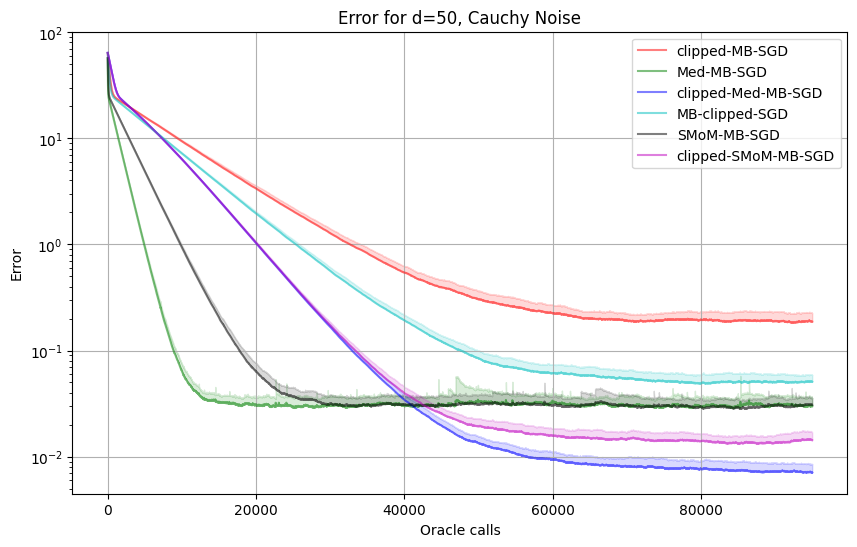

In [85]:
def gen_stocgrad(x, grad_f):
    noise = stats.cauchy.rvs(size=x.shape[0])
    true_grad = grad_f(x)
    stoc_grad = noise + true_grad
    return stoc_grad

dist_from_solution = 8

def do_epoch(method, d, learning_rate, clip_param=1, delta=0, m=1, need_many=False):
    A = matrices[d]
    f = lambda x: 0.5 * x.T @ A @ x
    grad_f = lambda x: A @ x
    curr_pos = dist_from_solution * np.ones(d) / np.sqrt(d)
    steps = 20000 + 1500 * d
    err, dst = [], []
    method.init_method(f, learning_rate=learning_rate, curr_pos=curr_pos.copy())
    buffer = np.zeros(shape=(int(need_many), d))
    buffer_size = 0
    for step in range(steps):
        if need_many:
            stoc_grad = gen_stocgrad(method.curr_pos, grad_f)
            buffer[step % need_many] = stoc_grad
            if step % need_many == 0 and step != 0:
                method.step(buffer, clip_param=clip_param, delta=delta, m=m)
                buffer = np.zeros(shape=(need_many, d))
        else:
            stoc_grad = gen_stocgrad(method.curr_pos, grad_f)
            method.step(stoc_grad, clip_param=clip_param)
    return method.err, method.dst

need_many = {"Clipped": 5, "Median": 5, "Clipped median": 5, "Mean of clipped": 5, "Smoothed Median Of Means": 10, "Clipped Smoothed Median Of Means": 10}
err = {"Clipped": {}, "Median": {}, "Clipped median": {}, "Mean of clipped": {}, "Smoothed Median Of Means": {}, "Clipped Smoothed Median Of Means": {}}
dst = {"Clipped": {}, "Median": {}, "Clipped median": {}, "Mean of clipped": {}, "Smoothed Median Of Means": {}, "Clipped Smoothed Median Of Means": {}}
methods = {"Clipped": SGDClipped, "Median": SGDMedian, "Clipped median": SGDClippedMedians, "Mean of clipped": SGDMeanOfClipped, "Smoothed Median Of Means": SmoothedMedianOfMeans, "Clipped Smoothed Median Of Means": ClippedSmoothedMedianOfMeans}
names = [x for x in need_many.keys()]
final_stats = {}
dims = [50]
epochs = 50
expon_mean = stats.expon.mean()
eps = 1e-2
name_mapping = {"Clipped": "clipped-MB-SGD", "Median": "Med-MB-SGD", "Mean of clipped": "MB-clipped-SGD", "Clipped median": "clipped-Med-MB-SGD", "Smoothed Median Of Means": "SMoM-MB-SGD", "Clipped Smoothed Median Of Means": "clipped-SMoM-MB-SGD"}
for d in dims:
    steps = 20000 + 1500 * d
    for learning_rate in "_":
        for clipping_param in "_":
            curr_methods = {}
            for name in names:
                err[name] = []
                dst[name] = []
                curr_methods[name] = methods[name](max(1, int(need_many[name])), dim=d)
            for epoch in tqdm(range(epochs)):
                for name in names:
                    err_local, dst_local = do_epoch(curr_methods[name], d, learning_rate=best_params[name][0],
                                                     clip_param=best_params[name][1], delta=best_params[name][2], m=best_params[name][3], need_many=need_many[name])
                    err[name].append(err_local)
                    dst[name].append(dst_local)
            colors = "rgbckm"
            fig, axes = plt.subplots(ncols=1, figsize=(10, 6))
            data = [err, dst]
            all_err["Cauchy"] = err
            print("Data created")
            titles = [f"Error for d={d}, Cauchy Noise", f"Distance from solution for d={d}"]
            for i in range(1):
                print(i)
                for j, name in enumerate(names):
                    arr = np.array(data[i][name])
                    mean = np.mean(arr, axis=0)
                    std = np.std(arr, axis=0)
                    X = np.arange(0, steps, 1)
                    if need_many[name]:
                        X = X[::need_many[name]][:mean.shape[0]]
                    smaller_eps = (mean < eps)
                    final_stats[(name, best_params[name][0], best_params[name][1])] = (mean[-1], smaller_eps.argmax())
                    axes.set_yscale("log")
                    axes.fill_between(X, mean, mean + std, color=colors[j], alpha=0.15)
                    axes.plot(X, mean, c=colors[j], label=f"{name_mapping[name]}", alpha=0.5)
                axes.legend()
                axes.set_xlabel("Oracle calls")
                axes.set_ylabel("Error")
                axes.grid()
                axes.set_title(titles[i])
            plt.show()

In [86]:
expon_mean = stats.expon.mean()

def gen_stocgrad(x, grad_f):
    noise = sample_mix(size=x.shape[0], dist1=stats.cauchy, dist2=stats.expon, mean_2=expon_mean)
    true_grad = grad_f(x)
    stoc_grad = noise + true_grad
    return stoc_grad

dist_from_solution = 8

def do_epoch(method, d, learning_rate, clip_param=1, delta=0, m=1, need_many=False):
    A = matrices[d]
    f = lambda x: 0.5 * x.T @ A @ x
    grad_f = lambda x: A @ x
    curr_pos = dist_from_solution * np.ones(d) / np.sqrt(d)
    steps = 20000 + 1000 * d
    err, dst = [], []
    method.init_method(f, learning_rate=learning_rate, curr_pos=curr_pos.copy())
    buffer = np.zeros(shape=(int(need_many), d))
    buffer_size = 0
    for step in range(steps):
        if need_many:
            stoc_grad = gen_stocgrad(method.curr_pos, grad_f)
            buffer[step % need_many] = stoc_grad
            if step % need_many == 0 and step != 0:
                method.step(buffer, clip_param=clip_param, delta=delta, m=m)
                buffer = np.zeros(shape=(need_many, d))
        else:
            stoc_grad = gen_stocgrad(method.curr_pos, grad_f)
            method.step(stoc_grad, clip_param=clip_param)
    return method.err, method.dst

params_evaluation_exp = {}

for d in [50]:
    steps = 20000 + 1000 * d
    err = {}
    epochs = 20
    print("d: ", d)
    params_evaluation_exp[d] = {x: {} for x in names}
    for learning_rate in [0.002, 0.004, 0.008, 0.01, 0.02, 0.04]:
        for clipping_param in [0.75, 1, 1.5, 2, 4, 8]:
            curr_methods = {}
            for name in names:
                err[name] = []
                curr_methods[name] = methods[name](max(1, int(need_many[name])), dim=d)
            for epoch in tqdm(range(epochs)):
                for name in names:
                    err_local, dst_local = do_epoch(curr_methods[name], d, learning_rate=learning_rate, 
                                                    clip_param=clipping_param, delta=best_params[name][2], m=best_params[name][3], need_many=need_many[name])
                    err[name].append(err_local)
            print(f"LR: {learning_rate}, Clipping: {clipping_param}", end=". ")
            for name in names:
                mean = np.array(err[name]).mean(axis=0)
                params_evaluation_exp[d][name][(learning_rate, clipping_param)] = mean.min() if mean.min() > 1e-2 else (np.argmax(mean < 1e-2) * (steps / mean.shape[0]))
                print(f"{name}: {params_evaluation_exp[d][name][(learning_rate, clipping_param)]};min={mean.min()}", end=", ")
            print()

d:  50


100%|██████████| 20/20 [07:00<00:00, 21.00s/it]


LR: 0.002, Clipping: 0.75. Clipped: 10.256893353370279;min=10.256893353370279, Median: 0.10115194166850834;min=0.10115194166850834, Clipped median: 0.3572578819862463;min=0.3572578819862463, Mean of clipped: 10.333277843714454;min=10.333277843714454, Smoothed Median Of Means: 0.02403108623756553;min=0.02403108623756553, Clipped Smoothed Median Of Means: 2.3264801382007128;min=2.3264801382007128, 


100%|██████████| 20/20 [06:58<00:00, 20.91s/it]


LR: 0.002, Clipping: 1. Clipped: 7.444718059392846;min=7.444718059392846, Median: 0.09991907724184809;min=0.09991907724184809, Clipped median: 0.17725419495371922;min=0.17725419495371922, Mean of clipped: 7.462558110415775;min=7.462558110415775, Smoothed Median Of Means: 0.024656370168818074;min=0.024656370168818074, Clipped Smoothed Median Of Means: 0.8595461081472535;min=0.8595461081472535, 


100%|██████████| 20/20 [06:58<00:00, 20.94s/it]


LR: 0.002, Clipping: 1.5. Clipped: 3.848166413053419;min=3.848166413053419, Median: 0.10105525974990408;min=0.10105525974990408, Clipped median: 0.11427240656655986;min=0.11427240656655986, Mean of clipped: 3.900373046094206;min=3.900373046094206, Smoothed Median Of Means: 0.02450243663699685;min=0.02450243663699685, Clipped Smoothed Median Of Means: 0.146250422136835;min=0.146250422136835, 


100%|██████████| 20/20 [06:57<00:00, 20.87s/it]


LR: 0.002, Clipping: 2. Clipped: 2.030256348268181;min=2.030256348268181, Median: 0.1014551269133293;min=0.1014551269133293, Clipped median: 0.10851538491553814;min=0.10851538491553814, Mean of clipped: 2.0165220136730704;min=2.0165220136730704, Smoothed Median Of Means: 0.024983021258701978;min=0.024983021258701978, Clipped Smoothed Median Of Means: 0.04668248390077292;min=0.04668248390077292, 


100%|██████████| 20/20 [07:01<00:00, 21.08s/it]


LR: 0.002, Clipping: 4. Clipped: 0.21298978595621013;min=0.21298978595621013, Median: 0.10325606479401177;min=0.10325606479401177, Clipped median: 0.10796915111832077;min=0.10796915111832077, Mean of clipped: 0.1718065418461041;min=0.1718065418461041, Smoothed Median Of Means: 0.025061226315298314;min=0.025061226315298314, Clipped Smoothed Median Of Means: 0.023068365679693944;min=0.023068365679693944, 


100%|██████████| 20/20 [06:57<00:00, 20.88s/it]


LR: 0.002, Clipping: 8. Clipped: 0.12207517965488439;min=0.12207517965488439, Median: 0.10138312513620946;min=0.10138312513620946, Clipped median: 0.10142091937661546;min=0.10142091937661546, Mean of clipped: 0.029624768563682558;min=0.029624768563682558, Smoothed Median Of Means: 0.023598414094057087;min=0.023598414094057087, Clipped Smoothed Median Of Means: 0.02204360663030786;min=0.02204360663030786, 


100%|██████████| 20/20 [06:56<00:00, 20.83s/it]


LR: 0.004, Clipping: 0.75. Clipped: 3.85485782885399;min=3.85485782885399, Median: 0.11631619989777335;min=0.11631619989777335, Clipped median: 0.11568310545105867;min=0.11568310545105867, Mean of clipped: 3.904894132666686;min=3.904894132666686, Smoothed Median Of Means: 0.037511091573316654;min=0.037511091573316654, Clipped Smoothed Median Of Means: 0.14720473148885754;min=0.14720473148885754, 


100%|██████████| 20/20 [06:56<00:00, 20.83s/it]


LR: 0.004, Clipping: 1. Clipped: 2.033376745963514;min=2.033376745963514, Median: 0.1133487489963716;min=0.1133487489963716, Clipped median: 0.11005989996584964;min=0.11005989996584964, Mean of clipped: 2.0403176884331993;min=2.0403176884331993, Smoothed Median Of Means: 0.035208251441520705;min=0.035208251441520705, Clipped Smoothed Median Of Means: 0.04656133847413729;min=0.04656133847413729, 


100%|██████████| 20/20 [06:53<00:00, 20.66s/it]


LR: 0.004, Clipping: 1.5. Clipped: 0.5875626115901036;min=0.5875626115901036, Median: 0.11515870012124407;min=0.11515870012124407, Clipped median: 0.10945959529177644;min=0.10945959529177644, Mean of clipped: 0.5590606727445232;min=0.5590606727445232, Smoothed Median Of Means: 0.03683297697716033;min=0.03683297697716033, Clipped Smoothed Median Of Means: 0.024546415750856403;min=0.024546415750856403, 


100%|██████████| 20/20 [06:54<00:00, 20.73s/it]


LR: 0.004, Clipping: 2. Clipped: 0.21512871075647735;min=0.21512871075647735, Median: 0.11675705806736998;min=0.11675705806736998, Clipped median: 0.10941966972699294;min=0.10941966972699294, Mean of clipped: 0.172229637414477;min=0.172229637414477, Smoothed Median Of Means: 0.0373285884820733;min=0.0373285884820733, Clipped Smoothed Median Of Means: 0.022434325273327227;min=0.022434325273327227, 


100%|██████████| 20/20 [06:54<00:00, 20.74s/it]


LR: 0.004, Clipping: 4. Clipped: 0.12575525288394676;min=0.12575525288394676, Median: 0.11085557415448988;min=0.11085557415448988, Clipped median: 0.1148544126239021;min=0.1148544126239021, Mean of clipped: 0.02784013192088768;min=0.02784013192088768, Smoothed Median Of Means: 0.03887556196169255;min=0.03887556196169255, Clipped Smoothed Median Of Means: 0.028743359074038476;min=0.028743359074038476, 


100%|██████████| 20/20 [06:56<00:00, 20.84s/it]


LR: 0.004, Clipping: 8. Clipped: 0.25104181927620534;min=0.25104181927620534, Median: 0.111758035386524;min=0.111758035386524, Clipped median: 0.11226052349519375;min=0.11226052349519375, Mean of clipped: 0.04883203884395196;min=0.04883203884395196, Smoothed Median Of Means: 0.0378310998835935;min=0.0378310998835935, Clipped Smoothed Median Of Means: 0.0352086170135053;min=0.0352086170135053, 


100%|██████████| 20/20 [06:55<00:00, 20.76s/it]


LR: 0.008, Clipping: 0.75. Clipped: 0.5862807884079102;min=0.5862807884079102, Median: 0.13861499541996627;min=0.13861499541996627, Clipped median: 0.10690147182902347;min=0.10690147182902347, Mean of clipped: 0.5619189129295461;min=0.5619189129295461, Smoothed Median Of Means: 0.06243436662222353;min=0.06243436662222353, Clipped Smoothed Median Of Means: 0.023465022108860478;min=0.023465022108860478, 


100%|██████████| 20/20 [06:53<00:00, 20.69s/it]


LR: 0.008, Clipping: 1. Clipped: 0.20817595039024323;min=0.20817595039024323, Median: 0.144276253314382;min=0.144276253314382, Clipped median: 0.10816800617821946;min=0.10816800617821946, Mean of clipped: 0.1671619641551652;min=0.1671619641551652, Smoothed Median Of Means: 0.06309089069448306;min=0.06309089069448306, Clipped Smoothed Median Of Means: 0.0231291533561946;min=0.0231291533561946, 


100%|██████████| 20/20 [26:17<00:00, 78.87s/it] 


LR: 0.008, Clipping: 1.5. Clipped: 0.1146783087211384;min=0.1146783087211384, Median: 0.14080247535550655;min=0.14080247535550655, Clipped median: 0.11119037226396575;min=0.11119037226396575, Mean of clipped: 0.03462610173437715;min=0.03462610173437715, Smoothed Median Of Means: 0.06359148560511278;min=0.06359148560511278, Clipped Smoothed Median Of Means: 0.0248304309181233;min=0.0248304309181233, 


100%|██████████| 20/20 [1:35:24<00:00, 286.22s/it]   


LR: 0.008, Clipping: 2. Clipped: 0.1223488461300218;min=0.1223488461300218, Median: 0.1359780020416075;min=0.1359780020416075, Clipped median: 0.1167025326885559;min=0.1167025326885559, Mean of clipped: 0.02929307696755724;min=0.02929307696755724, Smoothed Median Of Means: 0.0620036427218207;min=0.0620036427218207, Clipped Smoothed Median Of Means: 0.029596020686596967;min=0.029596020686596967, 


100%|██████████| 20/20 [06:53<00:00, 20.69s/it]


LR: 0.008, Clipping: 4. Clipped: 0.24430747535783368;min=0.24430747535783368, Median: 0.14284730730038026;min=0.14284730730038026, Clipped median: 0.13017297729719224;min=0.13017297729719224, Mean of clipped: 0.04970482339007325;min=0.04970482339007325, Smoothed Median Of Means: 0.06242503668743349;min=0.06242503668743349, Clipped Smoothed Median Of Means: 0.04314385829149499;min=0.04314385829149499, 


100%|██████████| 20/20 [06:53<00:00, 20.68s/it]


LR: 0.008, Clipping: 8. Clipped: 0.4800881421448467;min=0.4800881421448467, Median: 0.1405172685854503;min=0.1405172685854503, Clipped median: 0.13456324424118482;min=0.13456324424118482, Mean of clipped: 0.09322276843451081;min=0.09322276843451081, Smoothed Median Of Means: 0.061875554389720325;min=0.061875554389720325, Clipped Smoothed Median Of Means: 0.05819455533486784;min=0.05819455533486784, 


100%|██████████| 20/20 [06:54<00:00, 20.74s/it]


LR: 0.01, Clipping: 0.75. Clipped: 0.2778737052571178;min=0.2778737052571178, Median: 0.15067946753995365;min=0.15067946753995365, Clipped median: 0.1095672219812516;min=0.1095672219812516, Mean of clipped: 0.23305289371781593;min=0.23305289371781593, Smoothed Median Of Means: 0.07785863232580237;min=0.07785863232580237, Clipped Smoothed Median Of Means: 0.02219950132824971;min=0.02219950132824971, 


100%|██████████| 20/20 [06:55<00:00, 20.75s/it]


LR: 0.01, Clipping: 1. Clipped: 0.1196049122584909;min=0.1196049122584909, Median: 0.15647332968578734;min=0.15647332968578734, Clipped median: 0.1089768151683427;min=0.1089768151683427, Mean of clipped: 0.062818995612459;min=0.062818995612459, Smoothed Median Of Means: 0.0798679182980864;min=0.0798679182980864, Clipped Smoothed Median Of Means: 0.024048586083127228;min=0.024048586083127228, 


100%|██████████| 20/20 [06:55<00:00, 20.76s/it]


LR: 0.01, Clipping: 1.5. Clipped: 0.11572788573990604;min=0.11572788573990604, Median: 0.15427078025573576;min=0.15427078025573576, Clipped median: 0.11455153858700537;min=0.11455153858700537, Mean of clipped: 0.028515006036560386;min=0.028515006036560386, Smoothed Median Of Means: 0.07611706023340685;min=0.07611706023340685, Clipped Smoothed Median Of Means: 0.0289501204175856;min=0.0289501204175856, 


100%|██████████| 20/20 [06:58<00:00, 20.94s/it]


LR: 0.01, Clipping: 2. Clipped: 0.16274757522296224;min=0.16274757522296224, Median: 0.1524719557351221;min=0.1524719557351221, Clipped median: 0.11768759009553424;min=0.11768759009553424, Mean of clipped: 0.03602967204471362;min=0.03602967204471362, Smoothed Median Of Means: 0.07859697977910389;min=0.07859697977910389, Clipped Smoothed Median Of Means: 0.03383895186868827;min=0.03383895186868827, 


100%|██████████| 20/20 [06:56<00:00, 20.81s/it]


LR: 0.01, Clipping: 4. Clipped: 0.299237151231771;min=0.299237151231771, Median: 0.1524809253082072;min=0.1524809253082072, Clipped median: 0.13988820558924003;min=0.13988820558924003, Mean of clipped: 0.06122944066816742;min=0.06122944066816742, Smoothed Median Of Means: 0.07637388173518393;min=0.07637388173518393, Clipped Smoothed Median Of Means: 0.05448868193684535;min=0.05448868193684535, 


100%|██████████| 20/20 [1:34:29<00:00, 283.46s/it]  


LR: 0.01, Clipping: 8. Clipped: 0.567510753232489;min=0.567510753232489, Median: 0.15354204011144484;min=0.15354204011144484, Clipped median: 0.14907780789903685;min=0.14907780789903685, Mean of clipped: 0.11618649132818545;min=0.11618649132818545, Smoothed Median Of Means: 0.07858799805067777;min=0.07858799805067777, Clipped Smoothed Median Of Means: 0.0724291210887184;min=0.0724291210887184, 


100%|██████████| 20/20 [06:59<00:00, 20.98s/it]


LR: 0.02, Clipping: 0.75. Clipped: 0.12480044385970457;min=0.12480044385970457, Median: 0.22234799842661634;min=0.22234799842661634, Clipped median: 0.11448960942410438;min=0.11448960942410438, Mean of clipped: 0.03046677236991772;min=0.03046677236991772, Smoothed Median Of Means: 0.14699000352999494;min=0.14699000352999494, Clipped Smoothed Median Of Means: 0.02856921254692386;min=0.02856921254692386, 


100%|██████████| 20/20 [07:02<00:00, 21.14s/it]


LR: 0.02, Clipping: 1. Clipped: 0.15954325419729454;min=0.15954325419729454, Median: 0.22494196894025;min=0.22494196894025, Clipped median: 0.12021072760828837;min=0.12021072760828837, Mean of clipped: 0.03714957174433524;min=0.03714957174433524, Smoothed Median Of Means: 0.146302337461152;min=0.146302337461152, Clipped Smoothed Median Of Means: 0.03195294161529094;min=0.03195294161529094, 


100%|██████████| 20/20 [06:57<00:00, 20.86s/it]


LR: 0.02, Clipping: 1.5. Clipped: 0.22737154229667705;min=0.22737154229667705, Median: 0.2270638964676682;min=0.2270638964676682, Clipped median: 0.12991426395908506;min=0.12991426395908506, Mean of clipped: 0.0503594259053317;min=0.0503594259053317, Smoothed Median Of Means: 0.14816896793722262;min=0.14816896793722262, Clipped Smoothed Median Of Means: 0.04405698455007161;min=0.04405698455007161, 


100%|██████████| 20/20 [06:58<00:00, 20.92s/it]


LR: 0.02, Clipping: 2. Clipped: 0.3048012191724448;min=0.3048012191724448, Median: 0.2289185361329275;min=0.2289185361329275, Clipped median: 0.13757509602131945;min=0.13757509602131945, Mean of clipped: 0.061608165480601176;min=0.061608165480601176, Smoothed Median Of Means: 0.14242725791399666;min=0.14242725791399666, Clipped Smoothed Median Of Means: 0.052336594013857596;min=0.052336594013857596, 


100%|██████████| 20/20 [06:58<00:00, 20.94s/it]


LR: 0.02, Clipping: 4. Clipped: 0.5839388630027791;min=0.5839388630027791, Median: 0.2162509061445912;min=0.2162509061445912, Clipped median: 0.1834921728667717;min=0.1834921728667717, Mean of clipped: 0.12586806354507699;min=0.12586806354507699, Smoothed Median Of Means: 0.1511470411022648;min=0.1511470411022648, Clipped Smoothed Median Of Means: 0.09869688932937186;min=0.09869688932937186, 


100%|██████████| 20/20 [07:02<00:00, 21.14s/it]


LR: 0.02, Clipping: 8. Clipped: 1.1776319197856768;min=1.1776319197856768, Median: 0.2187722208076249;min=0.2187722208076249, Clipped median: 0.2166822488695735;min=0.2166822488695735, Mean of clipped: 0.24641829093045947;min=0.24641829093045947, Smoothed Median Of Means: 0.14512421510540405;min=0.14512421510540405, Clipped Smoothed Median Of Means: 0.13129896945933311;min=0.13129896945933311, 


100%|██████████| 20/20 [07:03<00:00, 21.18s/it]


LR: 0.04, Clipping: 0.75. Clipped: 0.22516176996363946;min=0.22516176996363946, Median: 63.41358229710271;min=63.41358229710271, Clipped median: 0.13186728727105118;min=0.13186728727105118, Mean of clipped: 0.049192239298552466;min=0.049192239298552466, Smoothed Median Of Means: 63.71255700892054;min=63.71255700892054, Clipped Smoothed Median Of Means: 0.043281087288759616;min=0.043281087288759616, 


100%|██████████| 20/20 [06:58<00:00, 20.91s/it]


LR: 0.04, Clipping: 1. Clipped: 0.282556693973196;min=0.282556693973196, Median: 64.0892245216353;min=64.0892245216353, Clipped median: 0.14127552277178962;min=0.14127552277178962, Mean of clipped: 0.060927536320664485;min=0.060927536320664485, Smoothed Median Of Means: 64.40846020981022;min=64.40846020981022, Clipped Smoothed Median Of Means: 0.05673374425723508;min=0.05673374425723508, 


100%|██████████| 20/20 [06:55<00:00, 20.77s/it]


LR: 0.04, Clipping: 1.5. Clipped: 0.45679487158555937;min=0.45679487158555937, Median: 63.10402825967883;min=63.10402825967883, Clipped median: 0.15568889880076406;min=0.15568889880076406, Mean of clipped: 0.09596106457298752;min=0.09596106457298752, Smoothed Median Of Means: 62.95698881135162;min=62.95698881135162, Clipped Smoothed Median Of Means: 0.07828498669553409;min=0.07828498669553409, 


100%|██████████| 20/20 [06:54<00:00, 20.72s/it]


LR: 0.04, Clipping: 2. Clipped: 0.5917635705815397;min=0.5917635705815397, Median: 62.43497337403636;min=62.43497337403636, Clipped median: 0.1761649577766203;min=0.1761649577766203, Mean of clipped: 0.12379295482728496;min=0.12379295482728496, Smoothed Median Of Means: 63.5173370798927;min=63.5173370798927, Clipped Smoothed Median Of Means: 0.09879735546297522;min=0.09879735546297522, 


100%|██████████| 20/20 [06:56<00:00, 20.83s/it]


LR: 0.04, Clipping: 4. Clipped: 1.1855872440246498;min=1.1855872440246498, Median: 64.26739731749242;min=64.26739731749242, Clipped median: 0.27515785250602276;min=0.27515785250602276, Mean of clipped: 0.24272951184385677;min=0.24272951184385677, Smoothed Median Of Means: 64.0778318518554;min=64.0778318518554, Clipped Smoothed Median Of Means: 0.19042859690509525;min=0.19042859690509525, 


100%|██████████| 20/20 [06:55<00:00, 20.77s/it]

LR: 0.04, Clipping: 8. Clipped: 2.3006098119825524;min=2.3006098119825524, Median: 64.34198849522565;min=64.34198849522565, Clipped median: 0.40385491880691565;min=0.40385491880691565, Mean of clipped: 0.4748362126704773;min=0.4748362126704773, Smoothed Median Of Means: 64.67490277615163;min=64.67490277615163, Clipped Smoothed Median Of Means: 0.3337108250248877;min=0.3337108250248877, 


In [94]:
bp_exp = {}
for name in names: 
    bp_exp[name] = (1e2, 0, 0)
    for x, y in params_evaluation_exp[d][name].items():
        if y < 1e3:
            if bp_exp[name][0] < 1e3 and y < bp_exp[name][0]:
                bp_exp[name] = (y, *x)
        if y > 1e3:
            if bp_exp[name][0] < 1e3:
                bp_exp[name] = (y, *x)
            elif y < bp_exp[name][0]:
                bp_exp[name] = (y, *x)
bp_exp

{'Clipped': (0.1146783087211384, 0.008, 1.5),
 'Median': (0.09991907724184809, 0.002, 1),
 'Clipped median': (0.10142091937661546, 0.002, 8),
 'Mean of clipped': (0.02784013192088768, 0.004, 4),
 'Smoothed Median Of Means': (0.023598414094057087, 0.002, 8),
 'Clipped Smoothed Median Of Means': (0.02204360663030786, 0.002, 8)}

In [95]:
best_params = {key: (bp_exp[key][1], bp_exp[key][2], best_params[key][2], best_params[key][3]) for key in names}

100%|██████████| 50/50 [23:43<00:00, 28.46s/it]


Data created
0


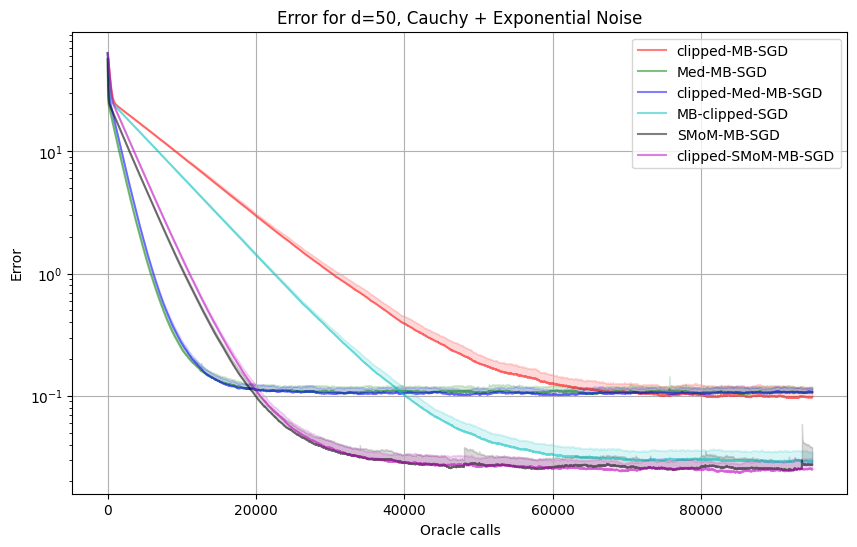

In [96]:
expon_mean = stats.expon.mean()

def gen_stocgrad(x, grad_f):
    noise = sample_mix(size=x.shape[0], dist1=stats.cauchy, dist2=stats.expon, mean_2=expon_mean)
    true_grad = grad_f(x)
    stoc_grad = noise + true_grad
    return stoc_grad

dist_from_solution = 8


def do_epoch(method, d, learning_rate, clip_param=1, delta=0, m=1, need_many=False):
    A = matrices[d]
    f = lambda x: 0.5 * x.T @ A @ x
    grad_f = lambda x: A @ x
    curr_pos = dist_from_solution * np.ones(d) / np.sqrt(d)
    steps = 20000 + 1500 * d
    err, dst = [], []
    method.init_method(f, learning_rate=learning_rate, curr_pos=curr_pos.copy())
    buffer = np.zeros(shape=(int(need_many), d))
    buffer_size = 0
    for step in range(steps):
        if need_many:
            stoc_grad = gen_stocgrad(method.curr_pos, grad_f)
            buffer[step % need_many] = stoc_grad
            if step % need_many == 0 and step != 0:
                method.step(buffer, clip_param=clip_param, delta=delta, m=m)
                buffer = np.zeros(shape=(need_many, d))
        else:
            stoc_grad = gen_stocgrad(method.curr_pos, grad_f)
            method.step(stoc_grad, clip_param=clip_param)
    return method.err, method.dst


err = {"Clipped": {}, "Median": {}, "Clipped median": {}, "Mean of clipped": {}, "Smoothed Median Of Means": {}, "Clipped Smoothed Median Of Means": {}}
dst = {"Clipped": {}, "Median": {}, "Clipped median": {}, "Mean of clipped": {}, "Smoothed Median Of Means": {}, "Clipped Smoothed Median Of Means": {}}
names = [x for x in need_many.keys()]
final_stats = {}
dims = [50]
epochs = 50
expon_mean = stats.expon.mean()
eps = 1e-2
for d in dims:
    steps = 20000 + 1500 * d
    for learning_rate in "_":
        for clipping_param in "_":
            curr_methods = {}
            for name in names:
                err[name] = []
                dst[name] = []
                curr_methods[name] = methods[name](max(1, int(need_many[name])), dim=d)
            for epoch in tqdm(range(epochs)):
                for name in names:
                    err_local, dst_local = do_epoch(curr_methods[name], d, learning_rate=best_params[name][0],
                                                     clip_param=best_params[name][1], delta=best_params[name][2], m=best_params[name][3], need_many=need_many[name])
                    err[name].append(err_local)
                    dst[name].append(dst_local)
            colors = "rgbckm"
            fig, axes = plt.subplots(ncols=1, figsize=(10, 6))
            data = [err, dst]
            all_err["Exp"] = err
            print("Data created")
            titles = [f"Error for d={d}, Cauchy + Exponential Noise", f"Distance from solution for d={d}"]
            for i in range(1):
                print(i)
                for j, name in enumerate(names):
                    arr = np.array(data[i][name])
                    mean = np.mean(arr, axis=0)
                    std = np.std(arr, axis=0)
                    X = np.arange(0, steps, 1)
                    if need_many[name]:
                        X = X[::need_many[name]][:mean.shape[0]]
                    smaller_eps = (mean < eps)
                    final_stats[(name, best_params[name][0], best_params[name][1])] = (mean[-1], smaller_eps.argmax())
                    axes.set_yscale("log")
                    axes.fill_between(X, mean, mean + std, color=colors[j], alpha=0.15)
                    axes.plot(X, mean, c=colors[j], label=f"{name_mapping[name]}", alpha=0.5)
                axes.legend()
                axes.set_xlabel("Oracle calls")
                axes.set_ylabel("Error")
                axes.grid()
                axes.set_title(titles[i])
            plt.show()

In [89]:
pareto_mean = stats.pareto.mean(b=3)

def gen_stocgrad(x, grad_f):
    noise = sample_mix(size=x.shape[0], dist1=stats.cauchy, dist2=stats.pareto, mean_2=pareto_mean, b=3)
    true_grad = grad_f(x)
    stoc_grad = noise + true_grad
    return stoc_grad

dist_from_solution = 8

def do_epoch(method, d, learning_rate, clip_param=1, delta=0, m=1, need_many=False):
    A = matrices[d]
    f = lambda x: 0.5 * x.T @ A @ x
    grad_f = lambda x: A @ x
    curr_pos = dist_from_solution * np.ones(d) / np.sqrt(d)
    steps = 20000 + 1000 * d
    err, dst = [], []
    method.init_method(f, learning_rate=learning_rate, curr_pos=curr_pos.copy())
    buffer = np.zeros(shape=(int(need_many), d))
    buffer_size = 0
    for step in range(steps):
        if need_many:
            stoc_grad = gen_stocgrad(method.curr_pos, grad_f)
            buffer[step % need_many] = stoc_grad
            if step % need_many == 0 and step != 0:
                method.step(buffer, clip_param=clip_param, delta=delta, m=m)
                buffer = np.zeros(shape=(need_many, d))
        else:
            stoc_grad = gen_stocgrad(method.curr_pos, grad_f)
            method.step(stoc_grad, clip_param=clip_param)
    return method.err, method.dst

params_evaluation_pareto = {}

for d in [50]:
    steps = 20000 + 1000 * d
    err = {}
    epochs = 20
    print("d: ", d)
    params_evaluation_pareto[d] = {x: {} for x in names}
    for learning_rate in [0.002, 0.004, 0.008, 0.01, 0.02, 0.04]:
        for clipping_param in [0.75, 1, 1.5, 2, 4, 8]:
            curr_methods = {}
            for name in names:
                err[name] = []
                curr_methods[name] = methods[name](max(1, int(need_many[name])), dim=d)
            for epoch in tqdm(range(epochs)):
                for name in names:
                    err_local, dst_local = do_epoch(curr_methods[name], d, learning_rate=learning_rate, 
                                                    clip_param=clipping_param, delta=best_params[name][2], m=best_params[name][3], need_many=need_many[name])
                    err[name].append(err_local)
            print(f"LR: {learning_rate}, Clipping: {clipping_param}", end=". ")
            for name in names:
                mean = np.array(err[name]).mean(axis=0)
                params_evaluation_pareto[d][name][(learning_rate, clipping_param)] = mean.min() if mean.min() > 1e-2 else (np.argmax(mean < 1e-2) * (steps / mean.shape[0]))
                print(f"{name}: {params_evaluation_pareto[d][name][(learning_rate, clipping_param)]};min={mean.min()}", end=", ")
            print()

d:  50


100%|██████████| 20/20 [07:40<00:00, 23.01s/it]


LR: 0.002, Clipping: 0.75. Clipped: 10.279046117217847;min=10.279046117217847, Median: 0.07340607895278764;min=0.07340607895278764, Clipped median: 0.22355778063208667;min=0.22355778063208667, Mean of clipped: 10.269545969623007;min=10.269545969623007, Smoothed Median Of Means: 0.02295915892195686;min=0.02295915892195686, Clipped Smoothed Median Of Means: 2.084733968233535;min=2.084733968233535, 


100%|██████████| 20/20 [07:41<00:00, 23.10s/it]


LR: 0.002, Clipping: 1. Clipped: 7.403088541933966;min=7.403088541933966, Median: 0.07366341256108269;min=0.07366341256108269, Clipped median: 0.11431631006720618;min=0.11431631006720618, Mean of clipped: 7.409922073311061;min=7.409922073311061, Smoothed Median Of Means: 0.02276749878382516;min=0.02276749878382516, Clipped Smoothed Median Of Means: 0.7205238027133742;min=0.7205238027133742, 


100%|██████████| 20/20 [07:39<00:00, 22.96s/it]


LR: 0.002, Clipping: 1.5. Clipped: 3.8587000585389375;min=3.8587000585389375, Median: 0.07425526699439154;min=0.07425526699439154, Clipped median: 0.08192546955753023;min=0.08192546955753023, Mean of clipped: 3.8603513439724715;min=3.8603513439724715, Smoothed Median Of Means: 0.022714369529434238;min=0.022714369529434238, Clipped Smoothed Median Of Means: 0.11831610581296578;min=0.11831610581296578, 


100%|██████████| 20/20 [07:39<00:00, 22.99s/it]


LR: 0.002, Clipping: 2. Clipped: 1.9899083923062624;min=1.9899083923062624, Median: 0.07344524013468874;min=0.07344524013468874, Clipped median: 0.07995736683958968;min=0.07995736683958968, Mean of clipped: 1.9914581349489686;min=1.9914581349489686, Smoothed Median Of Means: 0.02269085244792285;min=0.02269085244792285, Clipped Smoothed Median Of Means: 0.036007269259434246;min=0.036007269259434246, 


100%|██████████| 20/20 [07:40<00:00, 23.04s/it]


LR: 0.002, Clipping: 4. Clipped: 0.19395746814539444;min=0.19395746814539444, Median: 0.07594289266536824;min=0.07594289266536824, Clipped median: 0.07845084035479981;min=0.07845084035479981, Mean of clipped: 0.16530241332850365;min=0.16530241332850365, Smoothed Median Of Means: 0.022133468936656353;min=0.022133468936656353, Clipped Smoothed Median Of Means: 0.018639187315352867;min=0.018639187315352867, 


100%|██████████| 20/20 [07:38<00:00, 22.95s/it]


LR: 0.002, Clipping: 8. Clipped: 0.12459641713057132;min=0.12459641713057132, Median: 0.07310097061832051;min=0.07310097061832051, Clipped median: 0.074327855367526;min=0.074327855367526, Mean of clipped: 0.028624153655212738;min=0.028624153655212738, Smoothed Median Of Means: 0.02278302572304948;min=0.02278302572304948, Clipped Smoothed Median Of Means: 0.020467622523659794;min=0.020467622523659794, 


100%|██████████| 20/20 [07:40<00:00, 23.05s/it]


LR: 0.004, Clipping: 0.75. Clipped: 3.863625069943543;min=3.863625069943543, Median: 0.08707074848132826;min=0.08707074848132826, Clipped median: 0.0817926788429182;min=0.0817926788429182, Mean of clipped: 3.8350323581188164;min=3.8350323581188164, Smoothed Median Of Means: 0.03476488478922371;min=0.03476488478922371, Clipped Smoothed Median Of Means: 0.11412419425510853;min=0.11412419425510853, 


100%|██████████| 20/20 [07:40<00:00, 23.03s/it]


LR: 0.004, Clipping: 1. Clipped: 2.0270570230918117;min=2.0270570230918117, Median: 0.08443134629885851;min=0.08443134629885851, Clipped median: 0.0799207324391618;min=0.0799207324391618, Mean of clipped: 1.9953055799391055;min=1.9953055799391055, Smoothed Median Of Means: 0.03447416141831515;min=0.03447416141831515, Clipped Smoothed Median Of Means: 0.03834136238982681;min=0.03834136238982681, 


100%|██████████| 20/20 [07:39<00:00, 23.00s/it]


LR: 0.004, Clipping: 1.5. Clipped: 0.5711844581830762;min=0.5711844581830762, Median: 0.08530615367493556;min=0.08530615367493556, Clipped median: 0.08056003218131233;min=0.08056003218131233, Mean of clipped: 0.5505940651194997;min=0.5505940651194997, Smoothed Median Of Means: 0.03260593057369479;min=0.03260593057369479, Clipped Smoothed Median Of Means: 0.019601410596533662;min=0.019601410596533662, 


100%|██████████| 20/20 [07:41<00:00, 23.07s/it]


LR: 0.004, Clipping: 2. Clipped: 0.2057138131266262;min=0.2057138131266262, Median: 0.08591537947677128;min=0.08591537947677128, Clipped median: 0.07922375586007155;min=0.07922375586007155, Mean of clipped: 0.16022250842103417;min=0.16022250842103417, Smoothed Median Of Means: 0.031605806983740194;min=0.031605806983740194, Clipped Smoothed Median Of Means: 0.01910828808803375;min=0.01910828808803375, 


100%|██████████| 20/20 [07:41<00:00, 23.05s/it]


LR: 0.004, Clipping: 4. Clipped: 0.13755546537751423;min=0.13755546537751423, Median: 0.0848081831276273;min=0.0848081831276273, Clipped median: 0.08562891426070061;min=0.08562891426070061, Mean of clipped: 0.029151053683883064;min=0.029151053683883064, Smoothed Median Of Means: 0.03510332597514765;min=0.03510332597514765, Clipped Smoothed Median Of Means: 0.02520507901592055;min=0.02520507901592055, 


100%|██████████| 20/20 [07:39<00:00, 22.99s/it]


LR: 0.004, Clipping: 8. Clipped: 0.23823897860070914;min=0.23823897860070914, Median: 0.08497069054566295;min=0.08497069054566295, Clipped median: 0.07985528292560395;min=0.07985528292560395, Mean of clipped: 0.052694110823915154;min=0.052694110823915154, Smoothed Median Of Means: 0.034705426115124775;min=0.034705426115124775, Clipped Smoothed Median Of Means: 0.03253894148413808;min=0.03253894148413808, 


100%|██████████| 20/20 [07:39<00:00, 22.99s/it]


LR: 0.008, Clipping: 0.75. Clipped: 0.5937811008104233;min=0.5937811008104233, Median: 0.10842347519129367;min=0.10842347519129367, Clipped median: 0.0794533092232898;min=0.0794533092232898, Mean of clipped: 0.5507759555041976;min=0.5507759555041976, Smoothed Median Of Means: 0.05751978695257115;min=0.05751978695257115, Clipped Smoothed Median Of Means: 0.020177516914790257;min=0.020177516914790257, 


100%|██████████| 20/20 [07:42<00:00, 23.12s/it]


LR: 0.008, Clipping: 1. Clipped: 0.20102168901862463;min=0.20102168901862463, Median: 0.10658371915835499;min=0.10658371915835499, Clipped median: 0.07937952741896731;min=0.07937952741896731, Mean of clipped: 0.16244330568838503;min=0.16244330568838503, Smoothed Median Of Means: 0.05771874183032176;min=0.05771874183032176, Clipped Smoothed Median Of Means: 0.018520229685679422;min=0.018520229685679422, 


100%|██████████| 20/20 [07:38<00:00, 22.94s/it]


LR: 0.008, Clipping: 1.5. Clipped: 0.10901005929718673;min=0.10901005929718673, Median: 0.10470882234575152;min=0.10470882234575152, Clipped median: 0.08442330153594449;min=0.08442330153594449, Mean of clipped: 0.03443256760148933;min=0.03443256760148933, Smoothed Median Of Means: 0.05929872041123087;min=0.05929872041123087, Clipped Smoothed Median Of Means: 0.022966815169323328;min=0.022966815169323328, 


100%|██████████| 20/20 [07:40<00:00, 23.01s/it]


LR: 0.008, Clipping: 2. Clipped: 0.13013876003008368;min=0.13013876003008368, Median: 0.10819134428181068;min=0.10819134428181068, Clipped median: 0.08907369939220847;min=0.08907369939220847, Mean of clipped: 0.028659423884325585;min=0.028659423884325585, Smoothed Median Of Means: 0.05687683520777861;min=0.05687683520777861, Clipped Smoothed Median Of Means: 0.026800784136704996;min=0.026800784136704996, 


100%|██████████| 20/20 [07:42<00:00, 23.12s/it]


LR: 0.008, Clipping: 4. Clipped: 0.24609562329378076;min=0.24609562329378076, Median: 0.10732889822504502;min=0.10732889822504502, Clipped median: 0.09658471278192747;min=0.09658471278192747, Mean of clipped: 0.050051803314032174;min=0.050051803314032174, Smoothed Median Of Means: 0.05575501510537158;min=0.05575501510537158, Clipped Smoothed Median Of Means: 0.042176438001065714;min=0.042176438001065714, 


100%|██████████| 20/20 [07:38<00:00, 22.93s/it]


LR: 0.008, Clipping: 8. Clipped: 0.4935844445385616;min=0.4935844445385616, Median: 0.10671330504666647;min=0.10671330504666647, Clipped median: 0.10093142243048688;min=0.10093142243048688, Mean of clipped: 0.09910130646591317;min=0.09910130646591317, Smoothed Median Of Means: 0.05874542448331482;min=0.05874542448331482, Clipped Smoothed Median Of Means: 0.052980661966463095;min=0.052980661966463095, 


100%|██████████| 20/20 [07:41<00:00, 23.07s/it]


LR: 0.01, Clipping: 0.75. Clipped: 0.26460410904208087;min=0.26460410904208087, Median: 0.11922379869048676;min=0.11922379869048676, Clipped median: 0.07902250667450253;min=0.07902250667450253, Mean of clipped: 0.22755928490540883;min=0.22755928490540883, Smoothed Median Of Means: 0.06876691116429307;min=0.06876691116429307, Clipped Smoothed Median Of Means: 0.01934103344054912;min=0.01934103344054912, 


100%|██████████| 20/20 [07:43<00:00, 23.17s/it]


LR: 0.01, Clipping: 1. Clipped: 0.11295906480230755;min=0.11295906480230755, Median: 0.11675043264827237;min=0.11675043264827237, Clipped median: 0.08173608256740253;min=0.08173608256740253, Mean of clipped: 0.06388446494008865;min=0.06388446494008865, Smoothed Median Of Means: 0.06955190742031;min=0.06955190742031, Clipped Smoothed Median Of Means: 0.02136355411666988;min=0.02136355411666988, 


100%|██████████| 20/20 [07:40<00:00, 23.04s/it]


LR: 0.01, Clipping: 1.5. Clipped: 0.128673532316965;min=0.128673532316965, Median: 0.11885770294061351;min=0.11885770294061351, Clipped median: 0.0869961303669668;min=0.0869961303669668, Mean of clipped: 0.02915887827514872;min=0.02915887827514872, Smoothed Median Of Means: 0.07326286482220201;min=0.07326286482220201, Clipped Smoothed Median Of Means: 0.024565952474570496;min=0.024565952474570496, 


100%|██████████| 20/20 [07:42<00:00, 23.12s/it]


LR: 0.01, Clipping: 2. Clipped: 0.14870093715009752;min=0.14870093715009752, Median: 0.12320679492341982;min=0.12320679492341982, Clipped median: 0.08894234963611716;min=0.08894234963611716, Mean of clipped: 0.03458653516096245;min=0.03458653516096245, Smoothed Median Of Means: 0.06961653567247997;min=0.06961653567247997, Clipped Smoothed Median Of Means: 0.02999929886435503;min=0.02999929886435503, 


100%|██████████| 20/20 [07:43<00:00, 23.18s/it]


LR: 0.01, Clipping: 4. Clipped: 0.30712300251114477;min=0.30712300251114477, Median: 0.12142458101272768;min=0.12142458101272768, Clipped median: 0.10488699630946474;min=0.10488699630946474, Mean of clipped: 0.05798712273798966;min=0.05798712273798966, Smoothed Median Of Means: 0.06922400739923833;min=0.06922400739923833, Clipped Smoothed Median Of Means: 0.0472303170881576;min=0.0472303170881576, 


100%|██████████| 20/20 [07:39<00:00, 22.96s/it]


LR: 0.01, Clipping: 8. Clipped: 0.5588796194842185;min=0.5588796194842185, Median: 0.1185310779883959;min=0.1185310779883959, Clipped median: 0.10911981498001924;min=0.10911981498001924, Mean of clipped: 0.11944603587356792;min=0.11944603587356792, Smoothed Median Of Means: 0.06992841678062844;min=0.06992841678062844, Clipped Smoothed Median Of Means: 0.06337659374181723;min=0.06337659374181723, 


100%|██████████| 20/20 [07:43<00:00, 23.19s/it]


LR: 0.02, Clipping: 0.75. Clipped: 0.12012473556909482;min=0.12012473556909482, Median: 0.1770058859148224;min=0.1770058859148224, Clipped median: 0.08567740341654091;min=0.08567740341654091, Mean of clipped: 0.02853645521086543;min=0.02853645521086543, Smoothed Median Of Means: 0.1350247640071514;min=0.1350247640071514, Clipped Smoothed Median Of Means: 0.02632219595478206;min=0.02632219595478206, 


100%|██████████| 20/20 [07:45<00:00, 23.26s/it]


LR: 0.02, Clipping: 1. Clipped: 0.15883309496576353;min=0.15883309496576353, Median: 0.16753701946999136;min=0.16753701946999136, Clipped median: 0.08768762286715906;min=0.08768762286715906, Mean of clipped: 0.033114661229757085;min=0.033114661229757085, Smoothed Median Of Means: 0.1342922038264312;min=0.1342922038264312, Clipped Smoothed Median Of Means: 0.030187149978301485;min=0.030187149978301485, 


100%|██████████| 20/20 [07:46<00:00, 23.30s/it]


LR: 0.02, Clipping: 1.5. Clipped: 0.21774244425724562;min=0.21774244425724562, Median: 0.17279322910279835;min=0.17279322910279835, Clipped median: 0.09801850733836628;min=0.09801850733836628, Mean of clipped: 0.04661011643277378;min=0.04661011643277378, Smoothed Median Of Means: 0.13254322769943838;min=0.13254322769943838, Clipped Smoothed Median Of Means: 0.03946710705206712;min=0.03946710705206712, 


100%|██████████| 20/20 [07:44<00:00, 23.24s/it]


LR: 0.02, Clipping: 2. Clipped: 0.29834828650110556;min=0.29834828650110556, Median: 0.17605993046451576;min=0.17605993046451576, Clipped median: 0.10796584672623769;min=0.10796584672623769, Mean of clipped: 0.06319622614399883;min=0.06319622614399883, Smoothed Median Of Means: 0.12860811280978912;min=0.12860811280978912, Clipped Smoothed Median Of Means: 0.05016388572517587;min=0.05016388572517587, 


100%|██████████| 20/20 [07:45<00:00, 23.29s/it]


LR: 0.02, Clipping: 4. Clipped: 0.5692546947847973;min=0.5692546947847973, Median: 0.17485906258151576;min=0.17485906258151576, Clipped median: 0.1418907586114335;min=0.1418907586114335, Mean of clipped: 0.1256210937673007;min=0.1256210937673007, Smoothed Median Of Means: 0.12690219785833928;min=0.12690219785833928, Clipped Smoothed Median Of Means: 0.09057628144504765;min=0.09057628144504765, 


100%|██████████| 20/20 [07:44<00:00, 23.23s/it]


LR: 0.02, Clipping: 8. Clipped: 1.1531468802465594;min=1.1531468802465594, Median: 0.1766178266693949;min=0.1766178266693949, Clipped median: 0.16380137901565942;min=0.16380137901565942, Mean of clipped: 0.24320141392298295;min=0.24320141392298295, Smoothed Median Of Means: 0.11948577422462148;min=0.11948577422462148, Clipped Smoothed Median Of Means: 0.12052772905642521;min=0.12052772905642521, 


100%|██████████| 20/20 [07:43<00:00, 23.18s/it]


LR: 0.04, Clipping: 0.75. Clipped: 0.23210785059619538;min=0.23210785059619538, Median: 63.09769803291285;min=63.09769803291285, Clipped median: 0.09900897187305685;min=0.09900897187305685, Mean of clipped: 0.048339856373933544;min=0.048339856373933544, Smoothed Median Of Means: 61.72619670811631;min=61.72619670811631, Clipped Smoothed Median Of Means: 0.04008701247109218;min=0.04008701247109218, 


100%|██████████| 20/20 [07:44<00:00, 23.21s/it]


LR: 0.04, Clipping: 1. Clipped: 0.2974968264974426;min=0.2974968264974426, Median: 63.723976713808646;min=63.723976713808646, Clipped median: 0.11037386345750595;min=0.11037386345750595, Mean of clipped: 0.060919435690063715;min=0.060919435690063715, Smoothed Median Of Means: 64.15444537806106;min=64.15444537806106, Clipped Smoothed Median Of Means: 0.04965701045851988;min=0.04965701045851988, 


100%|██████████| 20/20 [07:43<00:00, 23.15s/it]


LR: 0.04, Clipping: 1.5. Clipped: 0.46583105965939636;min=0.46583105965939636, Median: 63.9295200741736;min=63.9295200741736, Clipped median: 0.12801712035131768;min=0.12801712035131768, Mean of clipped: 0.09302033794882078;min=0.09302033794882078, Smoothed Median Of Means: 63.4112161618837;min=63.4112161618837, Clipped Smoothed Median Of Means: 0.07247515579016083;min=0.07247515579016083, 


100%|██████████| 20/20 [07:45<00:00, 23.26s/it]


LR: 0.04, Clipping: 2. Clipped: 0.590340235510648;min=0.590340235510648, Median: 64.48746215959984;min=64.48746215959984, Clipped median: 0.144895046048729;min=0.144895046048729, Mean of clipped: 0.1262314717745856;min=0.1262314717745856, Smoothed Median Of Means: 62.23886821053554;min=62.23886821053554, Clipped Smoothed Median Of Means: 0.09262799229560516;min=0.09262799229560516, 


100%|██████████| 20/20 [07:44<00:00, 23.22s/it]


LR: 0.04, Clipping: 4. Clipped: 1.1539308232494263;min=1.1539308232494263, Median: 64.33561843796954;min=64.33561843796954, Clipped median: 0.2221264399735683;min=0.2221264399735683, Mean of clipped: 0.2401545156877955;min=0.2401545156877955, Smoothed Median Of Means: 63.8671930903682;min=63.8671930903682, Clipped Smoothed Median Of Means: 0.1752372846298031;min=0.1752372846298031, 


100%|██████████| 20/20 [07:43<00:00, 23.15s/it]

LR: 0.04, Clipping: 8. Clipped: 2.379195180571174;min=2.379195180571174, Median: 63.8099799612631;min=63.8099799612631, Clipped median: 0.32426749078783235;min=0.32426749078783235, Mean of clipped: 0.48700425303846784;min=0.48700425303846784, Smoothed Median Of Means: 63.34526864475301;min=63.34526864475301, Clipped Smoothed Median Of Means: 0.299479714211038;min=0.299479714211038, 


In [90]:
bp_par = {}
for name in names: 
    bp_par[name] = (1e2, 0, 0)
    for x, y in params_evaluation_pareto[d][name].items():
        if y < 1e3:
            if bp_par[name][0] < 1e3 and y < bp_par[name][0]:
                bp_par[name] = (y, *x)
        if y > 1e3:
            if bp_par[name][0] < 1e3:
                bp_par[name] = (y, *x)
            elif y < bp_par[name][0]:
                bp_par[name] = (y, *x)
bp_par

{'Clipped': (0.10901005929718673, 0.008, 1.5),
 'Median': (0.07310097061832051, 0.002, 8),
 'Clipped median': (0.074327855367526, 0.002, 8),
 'Mean of clipped': (0.02853645521086543, 0.02, 0.75),
 'Smoothed Median Of Means': (0.022133468936656353, 0.002, 4),
 'Clipped Smoothed Median Of Means': (0.018520229685679422, 0.008, 1)}

In [91]:
best_params = {key: (bp_par[key][1], bp_par[key][2], best_params[key][2], best_params[key][3]) for key in names}

100%|██████████| 50/50 [26:16<00:00, 31.53s/it]


Data created
0


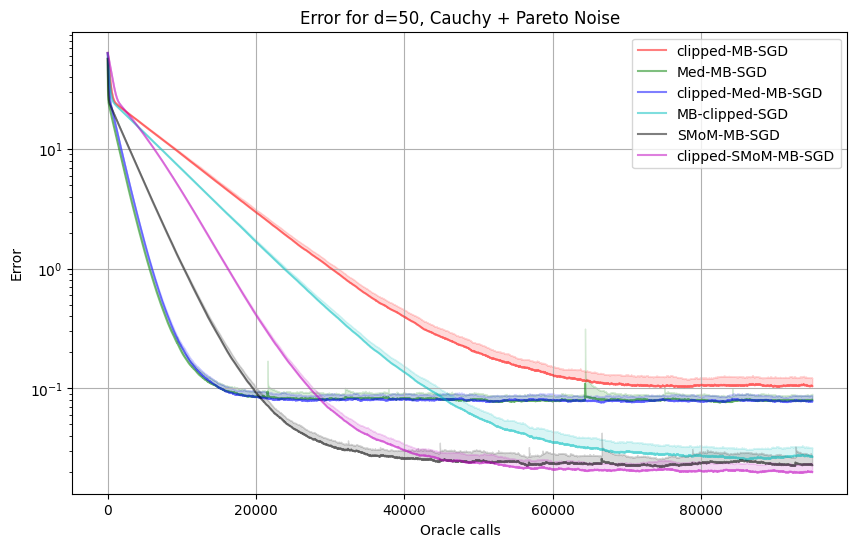

In [92]:
pareto_mean = stats.pareto.mean(b=3)

def gen_stocgrad(x, grad_f):
    noise = sample_mix(size=x.shape[0], dist1=stats.cauchy, dist2=stats.pareto, mean_2=pareto_mean, b=3)
    true_grad = grad_f(x)
    stoc_grad = noise + true_grad
    return stoc_grad

dist_from_solution = 8

def do_epoch(method, d, learning_rate, clip_param=1, delta=0, m=1, need_many=False):
    A = matrices[d]
    f = lambda x: 0.5 * x.T @ A @ x
    grad_f = lambda x: A @ x
    curr_pos = dist_from_solution * np.ones(d) / np.sqrt(d)
    steps = 20000 + 1500 * d
    err, dst = [], []
    method.init_method(f, learning_rate=learning_rate, curr_pos=curr_pos.copy())
    buffer = np.zeros(shape=(int(need_many), d))
    buffer_size = 0
    for step in range(steps):
        if need_many:
            stoc_grad = gen_stocgrad(method.curr_pos, grad_f)
            buffer[step % need_many] = stoc_grad
            if step % need_many == 0 and step != 0:
                method.step(buffer, clip_param=clip_param, delta=delta, m=m)
                buffer = np.zeros(shape=(need_many, d))
        else:
            stoc_grad = gen_stocgrad(method.curr_pos, grad_f)
            method.step(stoc_grad, clip_param=clip_param)
    return method.err, method.dst

err = {"Clipped": {}, "Median": {}, "Clipped median": {}, "Mean of clipped": {}, "Smoothed Median Of Means": {}, "Clipped Smoothed Median Of Means": {}}
dst = {"Clipped": {}, "Median": {}, "Clipped median": {}, "Mean of clipped": {}, "Smoothed Median Of Means": {}, "Clipped Smoothed Median Of Means": {}}
final_stats = {}
dims = [50]
epochs = 50
eps = 1e-2
for d in dims:
    steps = 20000 + 1500 * d
    for learning_rate in "_":
        for clipping_param in "_":
            curr_methods = {}
            for name in names:
                err[name] = []
                dst[name] = []
                curr_methods[name] = methods[name](max(1, int(need_many[name])), dim=d)
            for epoch in tqdm(range(epochs)):
                for name in names:
                    err_local, dst_local = do_epoch(curr_methods[name], d, learning_rate=best_params[name][0],
                                                     clip_param=best_params[name][1], delta=best_params[name][2], m=best_params[name][3], need_many=need_many[name])
                    err[name].append(err_local)
                    dst[name].append(dst_local)
            colors = "rgbckm"
            fig, axes = plt.subplots(ncols=1, figsize=(10, 6))
            data = [err, dst]
            print("Data created")
            all_err["Pareto"] = err
            titles = [f"Error for d={d}, Cauchy + Pareto Noise", f"Distance from solution for d={d}"]
            for i in range(1):
                print(i)
                for j, name in enumerate(names):
                    arr = np.array(data[i][name])
                    mean = np.mean(arr, axis=0)
                    std = np.std(arr, axis=0)
                    X = np.arange(0, steps, 1)
                    if need_many[name]:
                        X = X[::need_many[name]][:mean.shape[0]]
                    smaller_eps = (mean < eps)
                    final_stats[(name, best_params[name][0], best_params[name][1])] = (mean[-1], smaller_eps.argmax())
                    axes.set_yscale("log")
                    axes.fill_between(X, mean, mean + std, color=colors[j], alpha=0.15)
                    axes.plot(X, mean, c=colors[j], label=f"{name_mapping[name]}", alpha=0.5)
                axes.legend()
                axes.set_xlabel("Oracle calls")
                axes.set_ylabel("Error")
                axes.grid()
                axes.set_title(titles[i])
            plt.show()

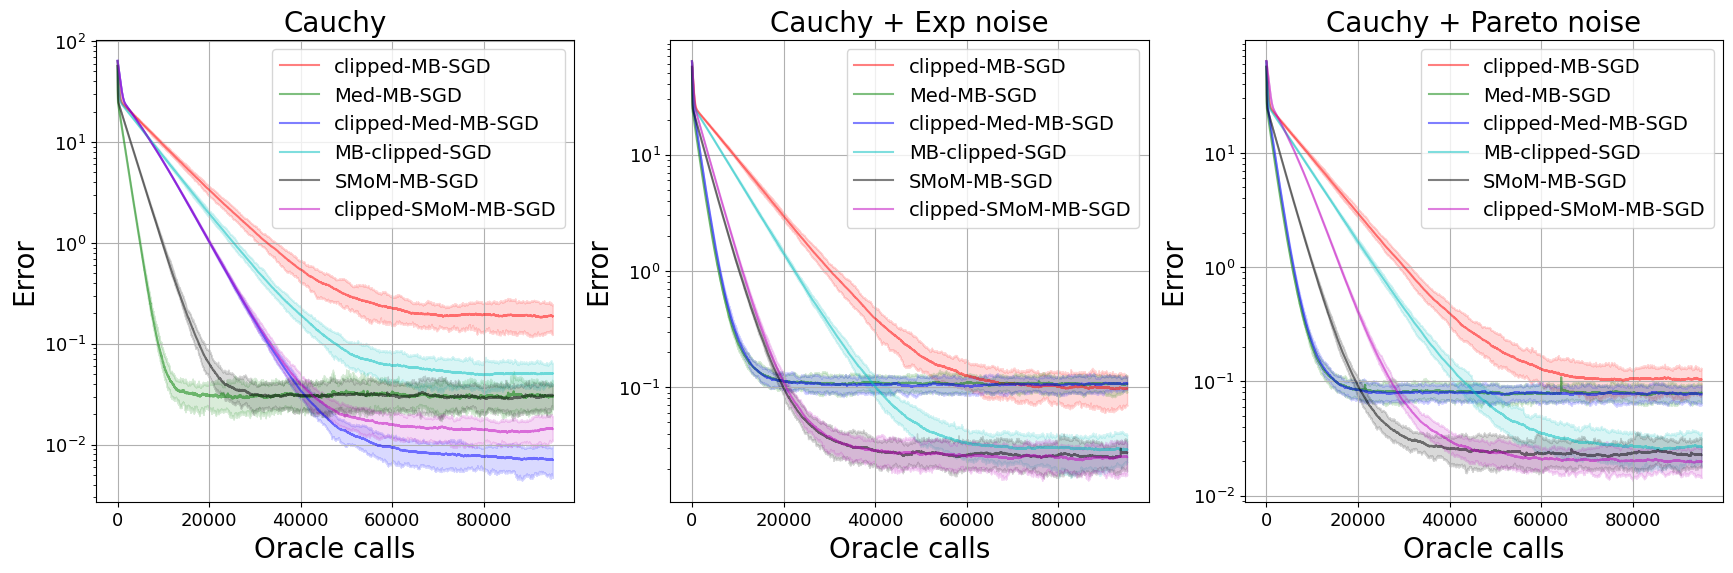

In [98]:
titles = {"Cauchy": "Cauchy", "Exp": "Cauchy + Exp noise", "Pareto": "Cauchy + Pareto noise"}
fig, axes = plt.subplots(ncols=3, figsize=(21, 6))
i = 0
for noise_name, title in titles.items():
    for j, name in enumerate(names):
        arr = np.array(all_err[noise_name][name])
        mean = np.mean(arr, axis=0)
        std = np.std(arr, axis=0)
        X = np.arange(0, steps, 1)
        if need_many[name]:
            X = X[::need_many[name]][:mean.shape[0]]
        smaller_eps = (mean < eps)
        axes[i].set_yscale("log")
        axes[i].fill_between(X, np.percentile(arr, q=5, axis=0), np.percentile(arr, q=95, axis=0), color=colors[j], alpha=0.15)
        axes[i].plot(X, mean, c=colors[j], label=f"{name_mapping[name]}", alpha=0.5)
    axes[i].legend(fontsize=14)
    axes[i].set_xlabel("Oracle calls", fontsize=20)
    axes[i].set_ylabel("Error", fontsize=20)
    axes[i].grid()
    axes[i].tick_params(axis="x", labelsize=13)
    axes[i].tick_params(axis="y", labelsize=13)
    axes[i].set_title(title, fontsize=20)
    i += 1
plt.show()

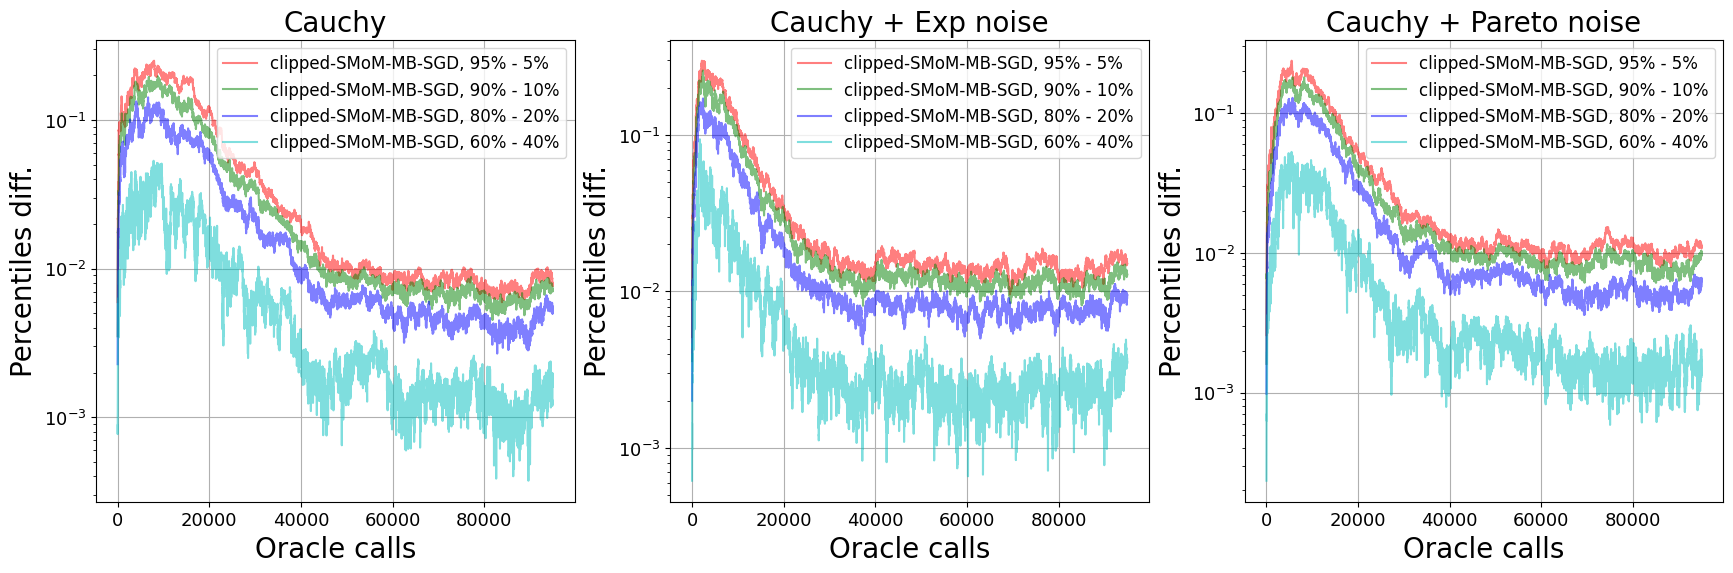

In [107]:
titles = {"Cauchy": "Cauchy", "Exp": "Cauchy + Exp noise", "Pareto": "Cauchy + Pareto noise"}
fig, axes = plt.subplots(ncols=3, figsize=(21, 6))
i = 0
for noise_name, title in titles.items():
    for name in ["Clipped Smoothed Median Of Means"]:
        for j, perc_step in enumerate([5, 10, 20, 40]):
            arr = np.array(all_err[noise_name][name])
            X = np.arange(0, steps, 1)
            if need_many[name]:
                X = X[::need_many[name]][:mean.shape[0]]
            axes[i].set_yscale("log")
            axes[i].plot(X, np.percentile(arr, q=100 - perc_step, axis=0) - np.percentile(arr, q=perc_step, axis=0), c=colors[j], label=f"{name_mapping[name]}, {100 - perc_step}% - {perc_step}%", alpha=0.5)
    axes[i].legend(fontsize=12)
    axes[i].set_xlabel("Oracle calls", fontsize=20)
    axes[i].set_ylabel("Percentiles diff.", fontsize=20)
    axes[i].grid()
    axes[i].tick_params(axis="x", labelsize=13)
    axes[i].tick_params(axis="y", labelsize=13)
    axes[i].set_title(title, fontsize=20)
    i += 1
plt.show()

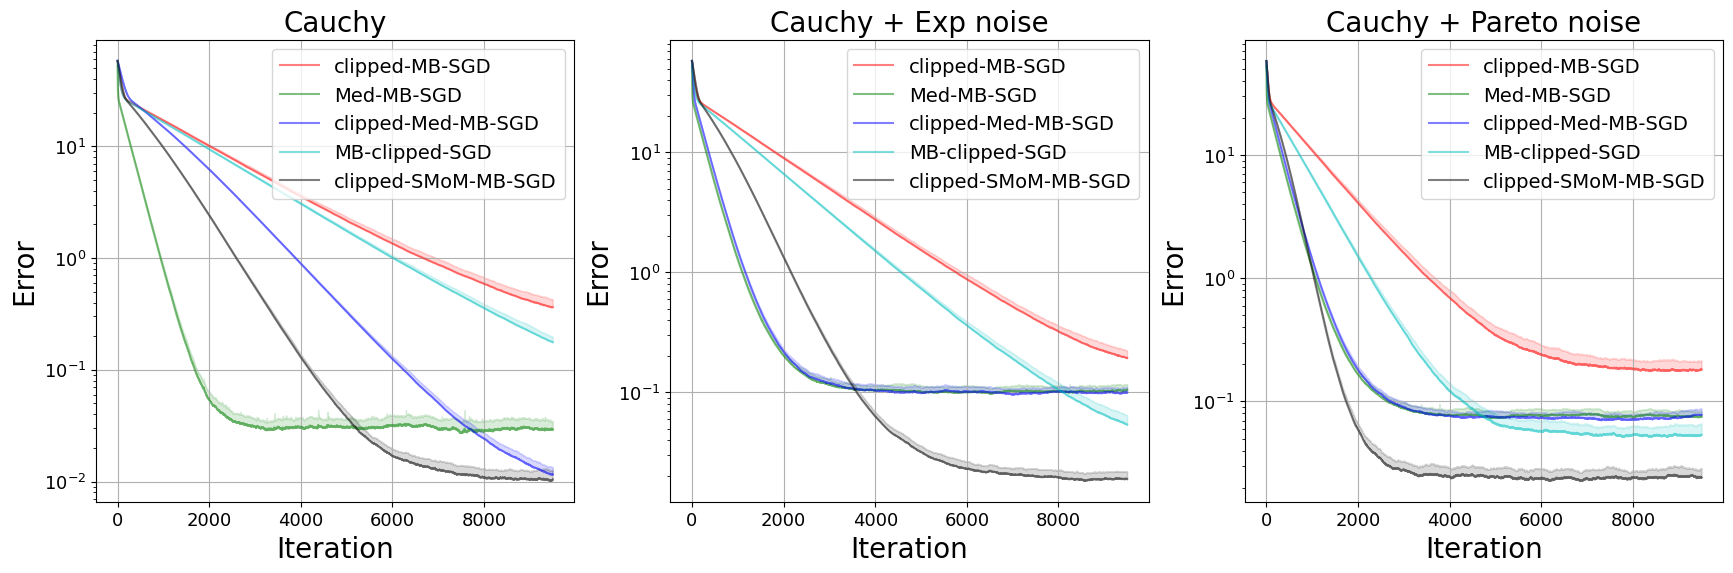

In [18]:
titles = {"Cauchy": "Cauchy", "Exp": "Cauchy + Exp noise", "Pareto": "Cauchy + Pareto noise"}
fig, axes = plt.subplots(ncols=3, figsize=(21, 6))
i = 0
for noise_name, title in titles.items():
    for j, name in enumerate(names):
        arr = np.array(all_err[noise_name][name])
        mean = np.mean(arr, axis=0)[:9499]
        std = np.std(arr, axis=0)[:9499]
        X = np.arange(0, mean.shape[0], 1)
        smaller_eps = (mean < eps)
        axes[i].set_yscale("log")
        axes[i].fill_between(X, mean, mean + std, color=colors[j], alpha=0.15)
        axes[i].plot(X, mean, c=colors[j], label=f"{name_mapping[name]}", alpha=0.5)
    axes[i].legend(fontsize=14)
    axes[i].set_xlabel("Iteration", fontsize=20)
    axes[i].set_ylabel("Error", fontsize=20)
    axes[i].grid()
    axes[i].tick_params(axis="x", labelsize=13)
    axes[i].tick_params(axis="y", labelsize=13)
    axes[i].set_title(title, fontsize=20)
    i += 1
plt.show()